# 2022 Travelers Modeling Competition

## Project Description
You work for Peace of Mind Insurance Company in their personal automotive insurance department as a modeler. For personal auto, anyone that asks for an estimated price for a policy from your company (also known as a quote) will receive one. However, of those quoted, only a fraction will choose your company as their insurer (versus other companies they also received quotes from). Your team has been asked to build what’s known as a conversion model, with the goal of understanding the population of policies Peace of Mind Insurance Company is most likely to write (a.k.a. issue or convert). In other words, what types of customers is your company writing over its competitors?

**Your goals in this competition are as follows:**

* Identify quoted policies that your company will convert (a.k.a. issue)
* Understand key characteristics of policies your company tends to write, as well as those they tend not to write (e.g. understand quoted policies with both high and low conversion rates)
* Provide a recommendation on how this information could be leveraged at Peace of Mind Insurance

### Data Description
The data provided to you and your team consists of variables describing customers that asked for quotes. There are three datasets: at the policy, driver, and vehicle levels. Each row of the policy dataset corresponds to a single policy, which may be associated with multiple drivers and vehicles. Likewise, each row of the driver dataset represents a single driver, and each row of the vehicle dataset represents a single vehicle. It's easy to check that each driver and each vehicle are associated with just one policy. You may assume that all members on a policy live at the same address.

Your company was only able to convert a fraction of the policies found in this sample. The policy dataset also has a training and test split variable called split. Note that the conversion indicator (the response variable) is missing for policies in the test split. Your task is to build a model on the training data and apply your model to predict the conversion indicator for each policy in test data.

**Policies.csv**

policy_id: Unique customer identifier

Quote_dt: Date the quote was submitted

quoted_amt: Quote amount (US dollars)

Prior_carrier_grp: Prior carrier group

Cov_package_type: Level of coverage needed

discount: Whether or not a discount was applied to the quote amount

number_drivers: Number of drivers

credit_score: Credit score of primary policy holder

num_loaned_veh: Number of vehicles on policy that have a loan associated with them

num_owned_veh: Number of owned vehicles on the policy

num_leased_veh: Number of leased vehicles on the policy

total_number_veh: Total number vehicles on the policy

primary_parking: Where car(s) are primarily parked

CAT_zone: Catastrophe risk zone

Home_policy_ind: Does customer has existing home insurance policy with Peace of Mind

zip: US zip code of policy holder

state_id: State of policy holder

county_name: County of policy holder

Agent_cd: Unique agent code (8 digits)

split: Train/Test split

convert_ind: Conversion indicator (0=no, 1=yes). This is the response variable

**Drivers.csv:**

policy_id: Unique customer identifier

gender: Gender of driver

age: Age of driver

high_education_ind: Higher education indicator

safty_rating: Safety rating index of driver

living_status: Driver’s living status (levels = ‘own’, ‘rent’, ‘neither’)

**Vehicles.csv:**

policy_id: Unique customer identifier

car_no: Unique car identifier (per policy)

ownership_type: Whether the car is loaned, owned or leased

color: Vehicle color

age: Vehicle age

make_model: Make and model of the vehicle

NOTE
Training and Test sets are combined across the files, and need to be separated manually by your group!

************

In [1]:
# Importing basic libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

## Importing Data

In [2]:
data = pd.read_csv("policies_train.csv")

In [3]:
vehicles = pd.read_csv("vehicles.csv")

In [4]:
drivers = pd.read_csv("drivers.csv")

In [5]:
test = pd.read_csv("policies_test.csv")

In [7]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 150

**Checking the number of rows and columns in the given datasets**

In [8]:
data.shape

(36871, 22)

In [9]:
vehicles.shape

(169237, 7)

In [10]:
drivers.shape

(106294, 7)

In [11]:
test.shape

(12291, 22)

In [12]:
# Checking first few rows of policies train dataset
data.head()

,Unnamed: 0,Quote_dt,discount,Home_policy_ind,zip,state_id,county_name,Agent_cd,quoted_amt,Prior_carrier_grp,credit_score,Cov_package_type,CAT_zone,policy_id,number_drivers,num_loaned_veh,num_owned_veh,num_leased_veh,total_number_veh,convert_ind,split,primary_parking
0,1,28-01-2015,Yes,Y,10465.0,NY,Bronx,15973623.0,"$5,153",Carrier_1,613.0,High,2.0,policy_87209,2,1,2,0,3,0,Train,home/driveway
1,3,03-09-2018,No,N,11548.0,NY,Nassau,32759856.0,"$3,090",Carrier_4,631.0,Medium,2.0,policy_91413,2,1,2,1,4,0,Train,unknown
2,5,18-05-2016,No,N,14622.0,NY,Monroe,15675431.0,"$14,917",Carrier_3,602.0,Medium,4.0,policy_71845,2,0,1,2,3,0,Train,unknown
3,6,17-11-2016,No,N,32811.0,FL,Orange,91762319.0,"$4,620",Carrier_4,704.0,High,1.0,policy_29027,1,2,2,0,4,0,Train,parking garage
4,7,04-07-2017,No,N,10306.0,NY,Richmond,97388179.0,"$11,470",Carrier_5,611.0,High,4.0,policy_75562,4,2,2,2,6,0,Train,home/driveway


In [13]:
# Checking the columns and their data types of policies train dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36871 entries, 0 to 36870
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         36871 non-null  int64  
 1   Quote_dt           36871 non-null  object 
 2   discount           36871 non-null  object 
 3   Home_policy_ind    36871 non-null  object 
 4   zip                36519 non-null  float64
 5   state_id           36871 non-null  object 
 6   county_name        36871 non-null  object 
 7   Agent_cd           32799 non-null  float64
 8   quoted_amt         36784 non-null  object 
 9   Prior_carrier_grp  33133 non-null  object 
 10  credit_score       36647 non-null  float64
 11  Cov_package_type   36278 non-null  object 
 12  CAT_zone           36690 non-null  float64
 13  policy_id          36871 non-null  object 
 14  number_drivers     36871 non-null  int64  
 15  num_loaned_veh     36871 non-null  int64  
 16  num_owned_veh      368

In [14]:
# Checking first few rows of vehciles dataset
vehicles.head()

,Unnamed: 0,policy_id,car_no,ownership_type,color,age,make_model
0,6,policy_74571,1,leased,other,4.0,BMW : R1200CL
1,7,policy_74571,2,owned,blue,3.0,ACURA : TL
2,15,policy_1998,1,owned,gray,7.0,BMW : 750LI
3,29,policy_28085,1,owned,gray,4.0,MERCEDES-BENZ : G55 AMG
4,34,policy_64282,1,owned,black,4.0,BMW : 550I GT


In [15]:
# Checking the columns and their data types of vehicles dataset
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169237 entries, 0 to 169236
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      169237 non-null  int64  
 1   policy_id       169237 non-null  object 
 2   car_no          169237 non-null  int64  
 3   ownership_type  169237 non-null  object 
 4   color           168165 non-null  object 
 5   age             168701 non-null  float64
 6   make_model      169237 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 9.0+ MB


In [16]:
# Checking first few rows of drivers dataset
drivers.head()

,Unnamed: 0,policy_id,gender,living_status,age,safty_rating,high_education_ind
0,2,policy_2,M,own,44,85.0,0.0
1,3,policy_2,M,own,44,63.0,1.0
2,4,policy_3,M,own,65,56.0,1.0
3,7,policy_5,M,rent,60,74.0,1.0
4,8,policy_5,F,dependent,20,30.0,0.0


In [17]:
# Checking the columns and their data types of drivers dataset
drivers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106294 entries, 0 to 106293
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          106294 non-null  int64  
 1   policy_id           106294 non-null  object 
 2   gender              106294 non-null  object 
 3   living_status       106244 non-null  object 
 4   age                 106294 non-null  int64  
 5   safty_rating        106217 non-null  float64
 6   high_education_ind  105751 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 5.7+ MB


In [18]:
# Creating a copy of policy train dataset
vdata = vehicles

-----------------
## Merging vehicles with policy
-----------------

In [19]:
vdata.head()

,Unnamed: 0,policy_id,car_no,ownership_type,color,age,make_model
0,6,policy_74571,1,leased,other,4.0,BMW : R1200CL
1,7,policy_74571,2,owned,blue,3.0,ACURA : TL
2,15,policy_1998,1,owned,gray,7.0,BMW : 750LI
3,29,policy_28085,1,owned,gray,4.0,MERCEDES-BENZ : G55 AMG
4,34,policy_64282,1,owned,black,4.0,BMW : 550I GT


In [20]:
vdata['make_model'].value_counts().shape

(1049,)

**We can see that the policy dataset has a column named 'make_model'. Keeping this column as it is in our analysis of the policies would make it very difficult to generate meaningful predictions as it has more than 1000 unique values. So we just keep the make of the cars and remove the model as the make could give us some insights on the policies that the company converts.**

In [21]:
vdata['make'] = vdata['make_model'].str.split(':', 0).str[0]
vdata.head()

,Unnamed: 0,policy_id,car_no,ownership_type,color,age,make_model,make
0,6,policy_74571,1,leased,other,4.0,BMW : R1200CL,BMW
1,7,policy_74571,2,owned,blue,3.0,ACURA : TL,ACURA
2,15,policy_1998,1,owned,gray,7.0,BMW : 750LI,BMW
3,29,policy_28085,1,owned,gray,4.0,MERCEDES-BENZ : G55 AMG,MERCEDES-BENZ
4,34,policy_64282,1,owned,black,4.0,BMW : 550I GT,BMW


In [22]:
vdata.drop(['make_model'], axis = 1, inplace = True)
vdata.head()

,Unnamed: 0,policy_id,car_no,ownership_type,color,age,make
0,6,policy_74571,1,leased,other,4.0,BMW
1,7,policy_74571,2,owned,blue,3.0,ACURA
2,15,policy_1998,1,owned,gray,7.0,BMW
3,29,policy_28085,1,owned,gray,4.0,MERCEDES-BENZ
4,34,policy_64282,1,owned,black,4.0,BMW


In [23]:
vdata['make'].unique()

array(['BMW ', 'ACURA ', 'MERCEDES-BENZ ', 'AUDI ', 'CADILLAC ', 'HONDA ',
       'CHEVROLET ', 'FORD ', 'GMC ', 'CHRYSLER ', 'NISSAN ', 'TOYOTA ',
       'MAZDA ', 'BUICK ', 'SATURN ', 'SUBARU ', 'DODGE ', 'RAM ',
       'SMART '], dtype=object)

In [24]:
vdata['make'].value_counts().shape

(19,)

**We can see that now the 'make' column has 19 unique values and we can analyse this column more effectively.**

### Transforming categorical variables

In [25]:
vdata = pd.get_dummies(vdata, columns = ['ownership_type', 'color', 'make' ])
vdata.head()

,Unnamed: 0,policy_id,car_no,age,ownership_type_leased,ownership_type_loaned,ownership_type_owned,color_black,color_blue,color_gray,color_other,color_red,color_silver,color_white,make_ACURA,make_AUDI,make_BMW,make_BUICK,make_CADILLAC,make_CHEVROLET,make_CHRYSLER,make_DODGE,make_FORD,make_GMC,make_HONDA,make_MAZDA,make_MERCEDES-BENZ,make_NISSAN,make_RAM,make_SATURN,make_SMART,make_SUBARU,make_TOYOTA
0,6,policy_74571,1,4.0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7,policy_74571,2,3.0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,15,policy_1998,1,7.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,29,policy_28085,1,4.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,34,policy_64282,1,4.0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Grouping by Policy Number

**- For attribute age -> mean, min, max is tabulated in seperate columns**

**- For attribute car_no, only the max value from the column is taken for each policy, as that gives total cars in that policy**

**- For all binary columns that we just transformed, the sum is taken to aggregate data for each policy**

In [26]:
bool_cols = [col for col in vdata 
             if np.isin(vdata[col].dropna().unique(), [0, 1]).all()]
bool_cols

['ownership_type_leased',
 'ownership_type_loaned',
 'ownership_type_owned',
 'color_black',
 'color_blue',
 'color_gray',
 'color_other',
 'color_red',
 'color_silver',
 'color_white',
 'make_ACURA ',
 'make_AUDI ',
 'make_BMW ',
 'make_BUICK ',
 'make_CADILLAC ',
 'make_CHEVROLET ',
 'make_CHRYSLER ',
 'make_DODGE ',
 'make_FORD ',
 'make_GMC ',
 'make_HONDA ',
 'make_MAZDA ',
 'make_MERCEDES-BENZ ',
 'make_NISSAN ',
 'make_RAM ',
 'make_SATURN ',
 'make_SMART ',
 'make_SUBARU ',
 'make_TOYOTA ']

In [27]:
vdata['age_min'] = vdata['age']
vdata['age_max'] = vdata['age']
d1 = {'car_no':'max'}
d2 = {'age':'mean'}
d3 = {'age_min':'min'}
d4 = {'age_max':'max'}
d5 = dict.fromkeys(bool_cols, 'sum')

d = {**d1, **d2, **d3, **d4, **d5}
vvdata = vdata.groupby('policy_id', as_index=False).agg(d)
vvdata.head()

,policy_id,car_no,age,age_min,age_max,ownership_type_leased,ownership_type_loaned,ownership_type_owned,color_black,color_blue,color_gray,color_other,color_red,color_silver,color_white,make_ACURA,make_AUDI,make_BMW,make_BUICK,make_CADILLAC,make_CHEVROLET,make_CHRYSLER,make_DODGE,make_FORD,make_GMC,make_HONDA,make_MAZDA,make_MERCEDES-BENZ,make_NISSAN,make_RAM,make_SATURN,make_SMART,make_SUBARU,make_TOYOTA
0,policy_100,6,7.333333,4.0,9.0,0,3,3,1,1,2,2,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,1,0,0,0,0,1
1,policy_1000,2,5.500000,3.0,8.0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,policy_10001,2,5.000000,2.0,8.0,0,0,2,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,policy_10002,5,7.200000,5.0,10.0,2,0,3,1,0,0,3,0,0,1,0,0,0,1,0,3,0,0,0,0,1,0,0,0,0,0,0,0,0
4,policy_10004,2,5.000000,1.0,9.0,0,1,1,0,0,1,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Inner Join

In [28]:
data_veh = pd.merge(left = data, right = vvdata, how = 'inner', on = 'policy_id')
data_veh.head()

,Unnamed: 0,Quote_dt,discount,Home_policy_ind,zip,state_id,county_name,Agent_cd,quoted_amt,Prior_carrier_grp,credit_score,Cov_package_type,CAT_zone,policy_id,number_drivers,num_loaned_veh,num_owned_veh,num_leased_veh,total_number_veh,convert_ind,split,primary_parking,car_no,age,age_min,age_max,ownership_type_leased,ownership_type_loaned,ownership_type_owned,color_black,color_blue,color_gray,color_other,color_red,color_silver,color_white,make_ACURA,make_AUDI,make_BMW,make_BUICK,make_CADILLAC,make_CHEVROLET,make_CHRYSLER,make_DODGE,make_FORD,make_GMC,make_HONDA,make_MAZDA,make_MERCEDES-BENZ,make_NISSAN,make_RAM,make_SATURN,make_SMART,make_SUBARU,make_TOYOTA
0,1,28-01-2015,Yes,Y,10465.0,NY,Bronx,15973623.0,"$5,153",Carrier_1,613.0,High,2.0,policy_87209,2,1,2,0,3,0,Train,home/driveway,4,5.25,3.0,7.0,0,2,2,0,0,1,1,0,1,1,0,0,2,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0
1,3,03-09-2018,No,N,11548.0,NY,Nassau,32759856.0,"$3,090",Carrier_4,631.0,Medium,2.0,policy_91413,2,1,2,1,4,0,Train,unknown,4,7.00,6.0,8.0,0,2,2,0,0,0,2,0,0,2,0,1,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0
2,5,18-05-2016,No,N,14622.0,NY,Monroe,15675431.0,"$14,917",Carrier_3,602.0,Medium,4.0,policy_71845,2,0,1,2,3,0,Train,unknown,4,4.50,4.0,5.0,0,1,3,0,1,0,1,1,0,1,1,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,6,17-11-2016,No,N,32811.0,FL,Orange,91762319.0,"$4,620",Carrier_4,704.0,High,1.0,policy_29027,1,2,2,0,4,0,Train,parking garage,5,6.00,4.0,10.0,1,2,2,0,0,1,1,0,3,0,0,1,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,7,04-07-2017,No,N,10306.0,NY,Richmond,97388179.0,"$11,470",Carrier_5,611.0,High,4.0,policy_75562,4,2,2,2,6,0,Train,home/driveway,3,7.00,6.0,8.0,0,1,2,0,0,0,0,0,2,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0


--------------------------------------
## Merging drivers to the previously merged dataset
--------------------------------------

In [29]:
# Creating a copy of drivers dataset
ddata = drivers

In [30]:
ddata.head()

,Unnamed: 0,policy_id,gender,living_status,age,safty_rating,high_education_ind
0,2,policy_2,M,own,44,85.0,0.0
1,3,policy_2,M,own,44,63.0,1.0
2,4,policy_3,M,own,65,56.0,1.0
3,7,policy_5,M,rent,60,74.0,1.0
4,8,policy_5,F,dependent,20,30.0,0.0


In [31]:
ddata.describe()

,Unnamed: 0,age,safty_rating,high_education_ind
count,106294.000000,106294.000000,106217.000000,105751.000000
mean,101689.784108,38.477318,69.411092,0.404488
std,60406.123405,18.432746,16.760435,0.490795
min,2.000000,16.000000,-28.000000,0.000000
25%,49453.750000,18.000000,60.000000,0.000000
50%,99647.500000,40.000000,72.000000,0.000000
75%,154169.750000,53.000000,82.000000,1.000000
max,206110.000000,147.000000,100.000000,1.000000


In [32]:
ddata[ddata['age']>100].describe()

,Unnamed: 0,age,safty_rating,high_education_ind
count,63.000000,63.000000,63.000000,63.000000
mean,95065.793651,109.317460,72.968254,0.571429
std,56555.864579,8.774643,16.966730,0.498847
min,4911.000000,101.000000,26.000000,0.000000
25%,58387.500000,103.000000,64.000000,0.000000
50%,83515.000000,107.000000,76.000000,1.000000
75%,143051.000000,113.500000,85.000000,1.000000
max,199618.000000,147.000000,97.000000,1.000000


**We can see that the age in a number of policies is greater than 100. This data is mostly inaccurate and since there is only a small number of data points with this inaccuracy, these can be removed.**

In [33]:
ddata = ddata.drop(ddata[ddata['age'] > 100].index)

In [34]:
ddata['age'].describe()

count    106231.000000
mean         38.435306
std          18.356055
min          16.000000
25%          18.000000
50%          40.000000
75%          53.000000
max         100.000000
Name: age, dtype: float64

### Transforming categorical variables

**We can group the age into bins to make it a categorical variable**

In [35]:
bins = [0,25,35,45,55,65,101]
labels = ['15-25','26-35','36-45','46-55','56-65','65+']
ddata['Age Group'] = pd.cut(ddata['age'], bins = bins, labels = labels)
ddata.head()

,Unnamed: 0,policy_id,gender,living_status,age,safty_rating,high_education_ind,Age Group
0,2,policy_2,M,own,44,85.0,0.0,36-45
1,3,policy_2,M,own,44,63.0,1.0,36-45
2,4,policy_3,M,own,65,56.0,1.0,56-65
3,7,policy_5,M,rent,60,74.0,1.0,56-65
4,8,policy_5,F,dependent,20,30.0,0.0,15-25


In [36]:
ddata = pd.get_dummies(ddata, columns = ['gender', 'living_status', 'Age Group' ,'high_education_ind'])
ddata.head()

,Unnamed: 0,policy_id,age,safty_rating,gender_F,gender_M,living_status_dependent,living_status_own,living_status_rent,Age Group_15-25,Age Group_26-35,Age Group_36-45,Age Group_46-55,Age Group_56-65,Age Group_65+,high_education_ind_0.0,high_education_ind_1.0
0,2,policy_2,44,85.0,0,1,0,1,0,0,0,1,0,0,0,1,0
1,3,policy_2,44,63.0,0,1,0,1,0,0,0,1,0,0,0,0,1
2,4,policy_3,65,56.0,0,1,0,1,0,0,0,0,0,1,0,0,1
3,7,policy_5,60,74.0,0,1,0,0,1,0,0,0,0,1,0,0,1
4,8,policy_5,20,30.0,1,0,1,0,0,1,0,0,0,0,0,1,0


In [37]:
ddata.head()

,Unnamed: 0,policy_id,age,safty_rating,gender_F,gender_M,living_status_dependent,living_status_own,living_status_rent,Age Group_15-25,Age Group_26-35,Age Group_36-45,Age Group_46-55,Age Group_56-65,Age Group_65+,high_education_ind_0.0,high_education_ind_1.0
0,2,policy_2,44,85.0,0,1,0,1,0,0,0,1,0,0,0,1,0
1,3,policy_2,44,63.0,0,1,0,1,0,0,0,1,0,0,0,0,1
2,4,policy_3,65,56.0,0,1,0,1,0,0,0,0,0,1,0,0,1
3,7,policy_5,60,74.0,0,1,0,0,1,0,0,0,0,1,0,0,1
4,8,policy_5,20,30.0,1,0,1,0,0,1,0,0,0,0,0,1,0


### Grouping by Policy Number

**- For attribute safety rating -> mean, min, max is tabulated in seperate columns**

**- For all binary columns that we just transformed, the sum is taken to aggregate data for each policy**

In [38]:
bool_cols1 = [col for col in ddata 
             if np.isin(ddata[col].dropna().unique(), [0, 1]).all()]
bool_cols1

['gender_F',
 'gender_M',
 'living_status_dependent',
 'living_status_own',
 'living_status_rent',
 'Age Group_15-25',
 'Age Group_26-35',
 'Age Group_36-45',
 'Age Group_46-55',
 'Age Group_56-65',
 'Age Group_65+',
 'high_education_ind_0.0',
 'high_education_ind_1.0']

In [39]:
ddata['safety_min'] = ddata['safty_rating']
ddata['safety_max'] = ddata['safty_rating']
d1 = {'safty_rating':'mean'}
d2 = {'safety_min':'min'}
d3 = {'safety_max':'max'}
d4 = dict.fromkeys(bool_cols1, 'sum')

d = {**d1, **d2, **d3, **d4}
dddata = ddata.groupby('policy_id', as_index=False).agg(d)
dddata.head()

,policy_id,safty_rating,safety_min,safety_max,gender_F,gender_M,living_status_dependent,living_status_own,living_status_rent,Age Group_15-25,Age Group_26-35,Age Group_36-45,Age Group_46-55,Age Group_56-65,Age Group_65+,high_education_ind_0.0,high_education_ind_1.0
0,policy_100,75.500000,75.0,76.0,1,1,1,1,0,1,0,0,1,0,0,1,1
1,policy_1000,50.000000,50.0,50.0,0,1,0,0,1,0,1,0,0,0,0,0,1
2,policy_10001,59.333333,45.0,71.0,2,1,2,1,0,2,0,1,0,0,0,2,1
3,policy_10002,76.000000,64.0,90.0,1,4,4,0,1,4,0,0,1,0,0,4,1
4,policy_10004,72.000000,29.0,86.0,2,3,3,2,0,3,1,0,0,1,0,3,1


### Inner Join

In [40]:
df_policy = pd.merge(left = data_veh, right = dddata, how = 'inner', on = 'policy_id')
df_policy.head()

,Unnamed: 0,Quote_dt,discount,Home_policy_ind,zip,state_id,county_name,Agent_cd,quoted_amt,Prior_carrier_grp,credit_score,Cov_package_type,CAT_zone,policy_id,number_drivers,num_loaned_veh,num_owned_veh,num_leased_veh,total_number_veh,convert_ind,split,primary_parking,car_no,age,age_min,age_max,ownership_type_leased,ownership_type_loaned,ownership_type_owned,color_black,color_blue,color_gray,color_other,color_red,color_silver,color_white,make_ACURA,make_AUDI,make_BMW,make_BUICK,make_CADILLAC,make_CHEVROLET,make_CHRYSLER,make_DODGE,make_FORD,make_GMC,make_HONDA,make_MAZDA,make_MERCEDES-BENZ,make_NISSAN,make_RAM,make_SATURN,make_SMART,make_SUBARU,make_TOYOTA,safty_rating,safety_min,safety_max,gender_F,gender_M,living_status_dependent,living_status_own,living_status_rent,Age Group_15-25,Age Group_26-35,Age Group_36-45,Age Group_46-55,Age Group_56-65,Age Group_65+,high_education_ind_0.0,high_education_ind_1.0
0,1,28-01-2015,Yes,Y,10465.0,NY,Bronx,15973623.0,"$5,153",Carrier_1,613.0,High,2.0,policy_87209,2,1,2,0,3,0,Train,home/driveway,4,5.25,3.0,7.0,0,2,2,0,0,1,1,0,1,1,0,0,2,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,74.00,70.0,78.0,1,1,0,0,2,0,0,1,0,1,0,1,1
1,3,03-09-2018,No,N,11548.0,NY,Nassau,32759856.0,"$3,090",Carrier_4,631.0,Medium,2.0,policy_91413,2,1,2,1,4,0,Train,unknown,4,7.00,6.0,8.0,0,2,2,0,0,0,2,0,0,2,0,1,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,70.00,61.0,79.0,1,1,0,0,2,0,0,1,1,0,0,1,1
2,5,18-05-2016,No,N,14622.0,NY,Monroe,15675431.0,"$14,917",Carrier_3,602.0,Medium,4.0,policy_71845,2,0,1,2,3,0,Train,unknown,4,4.50,4.0,5.0,0,1,3,0,1,0,1,1,0,1,1,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,81.50,69.0,94.0,1,1,0,2,0,0,0,1,0,0,1,0,2
3,6,17-11-2016,No,N,32811.0,FL,Orange,91762319.0,"$4,620",Carrier_4,704.0,High,1.0,policy_29027,1,2,2,0,4,0,Train,parking garage,5,6.00,4.0,10.0,1,2,2,0,0,1,1,0,3,0,0,1,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,66.00,66.0,66.0,1,0,1,0,0,1,0,0,0,0,0,1,0
4,7,04-07-2017,No,N,10306.0,NY,Richmond,97388179.0,"$11,470",Carrier_5,611.0,High,4.0,policy_75562,4,2,2,2,6,0,Train,home/driveway,3,7.00,6.0,8.0,0,1,2,0,0,0,0,0,2,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,74.25,54.0,83.0,3,1,3,1,0,3,0,1,0,0,0,4,0


In [41]:
# df_policy.to_csv('policy_merged.csv')

## Data cleaning on merged dataset

In [42]:
df_policy['county_name'].value_counts().shape

(112,)

**After running the XGBoost model, we observed from the feature importance plots that only the counties New York and Kings have coniderably high importance amongst all the counties, and there are more than 100 counties. So, only these counties are kept, while others are made zero.**

In [43]:
df_policy['county_name'] = np.where((df_policy['county_name'] == 'New York')|(df_policy['county_name'] =='Kings'), df_policy['county_name'], 0)

In [44]:
df_policy['county_name'].value_counts()

0           34985
New York      953
Kings         924
Name: county_name, dtype: int64

**Similary for Prior Carrier Group, only the carriers 3, 7, and 8 have coniderably high importance amongst all the carriers. So, only these carriers are kept, while others are made zero.**

In [45]:
df_policy['Prior_carrier_grp'] = np.where((df_policy['Prior_carrier_grp'] == 'Carrier_3')|(df_policy['Prior_carrier_grp'] =='Carrier_7')|(df_policy['Prior_carrier_grp'] =='Carrier_8'), df_policy['Prior_carrier_grp'], 0)

In [46]:
df_policy['Prior_carrier_grp'].value_counts()

0            26636
Carrier_3     3763
Carrier_8     3319
Carrier_7     3144
Name: Prior_carrier_grp, dtype: int64

In [47]:
df_policy.columns

Index(['Unnamed: 0', 'Quote_dt', 'discount', 'Home_policy_ind', 'zip',
       'state_id', 'county_name', 'Agent_cd', 'quoted_amt',
       'Prior_carrier_grp', 'credit_score', 'Cov_package_type', 'CAT_zone',
       'policy_id', 'number_drivers', 'num_loaned_veh', 'num_owned_veh',
       'num_leased_veh', 'total_number_veh', 'convert_ind', 'split',
       'primary_parking', 'car_no', 'age', 'age_min', 'age_max',
       'ownership_type_leased', 'ownership_type_loaned',
       'ownership_type_owned', 'color_black', 'color_blue', 'color_gray',
       'color_other', 'color_red', 'color_silver', 'color_white',
       'make_ACURA ', 'make_AUDI ', 'make_BMW ', 'make_BUICK ',
       'make_CADILLAC ', 'make_CHEVROLET ', 'make_CHRYSLER ', 'make_DODGE ',
       'make_FORD ', 'make_GMC ', 'make_HONDA ', 'make_MAZDA ',
       'make_MERCEDES-BENZ ', 'make_NISSAN ', 'make_RAM ', 'make_SATURN ',
       'make_SMART ', 'make_SUBARU ', 'make_TOYOTA ', 'safty_rating',
       'safety_min', 'safety_max', 'gen

**Only the top 5 'make' according to feature importance plots from XGBoost are kept while others are removed**

In [48]:
df_policy.drop(['make_ACURA ', 'make_BUICK ', 'make_CADILLAC ', 'make_CHRYSLER ', 'make_DODGE ','make_FORD ', 'make_GMC ','make_MAZDA ',
                'make_NISSAN ','make_RAM ','make_SATURN ','make_SMART ','make_SUBARU ','make_TOYOTA '], axis = 1, inplace = True)

In [49]:
df_policy.columns

Index(['Unnamed: 0', 'Quote_dt', 'discount', 'Home_policy_ind', 'zip',
       'state_id', 'county_name', 'Agent_cd', 'quoted_amt',
       'Prior_carrier_grp', 'credit_score', 'Cov_package_type', 'CAT_zone',
       'policy_id', 'number_drivers', 'num_loaned_veh', 'num_owned_veh',
       'num_leased_veh', 'total_number_veh', 'convert_ind', 'split',
       'primary_parking', 'car_no', 'age', 'age_min', 'age_max',
       'ownership_type_leased', 'ownership_type_loaned',
       'ownership_type_owned', 'color_black', 'color_blue', 'color_gray',
       'color_other', 'color_red', 'color_silver', 'color_white', 'make_AUDI ',
       'make_BMW ', 'make_CHEVROLET ', 'make_HONDA ', 'make_MERCEDES-BENZ ',
       'safty_rating', 'safety_min', 'safety_max', 'gender_F', 'gender_M',
       'living_status_dependent', 'living_status_own', 'living_status_rent',
       'Age Group_15-25', 'Age Group_26-35', 'Age Group_36-45',
       'Age Group_46-55', 'Age Group_56-65', 'Age Group_65+',
       'high_educati

In [50]:
# Checking the data in numerical columns
df_policy.describe()

,Unnamed: 0,zip,Agent_cd,credit_score,CAT_zone,number_drivers,num_loaned_veh,num_owned_veh,num_leased_veh,total_number_veh,convert_ind,car_no,age,age_min,age_max,ownership_type_leased,ownership_type_loaned,ownership_type_owned,color_black,color_blue,color_gray,color_other,color_red,color_silver,color_white,make_AUDI,make_BMW,make_CHEVROLET,make_HONDA,make_MERCEDES-BENZ,safty_rating,safety_min,safety_max,gender_F,gender_M,living_status_dependent,living_status_own,living_status_rent,Age Group_15-25,Age Group_26-35,Age Group_36-45,Age Group_46-55,Age Group_56-65,Age Group_65+,high_education_ind_0.0,high_education_ind_1.0
count,36862.000000,36510.000000,3.279100e+04,36638.000000,36681.000000,36862.000000,36862.000000,36862.000000,36862.000000,36862.000000,36862.000000,36862.000000,36852.000000,36852.000000,36852.000000,36862.000000,36862.000000,36862.000000,36862.000000,36862.000000,36862.000000,36862.00000,36862.000000,36862.000000,36862.000000,36862.000000,36862.000000,36862.000000,36862.000000,36862.000000,36849.000000,36849.000000,36849.000000,36862.000000,36862.000000,36862.000000,36862.000000,36862.000000,36862.000000,36862.000000,36862.000000,36862.000000,36862.000000,36862.000000,36862.000000,36862.000000
mean,24522.768488,22448.670857,5.461499e+07,641.515339,2.872195,2.159568,1.305545,1.645624,0.501899,3.453068,0.111714,3.442190,5.001084,3.172365,6.976501,0.496826,1.295562,1.649802,0.490614,0.489718,0.483560,0.48999,0.486789,0.488606,0.491373,0.204981,0.611443,0.302995,0.545385,0.490261,70.605594,62.438601,78.004966,1.058163,1.100401,0.802995,0.740356,0.614400,0.802697,0.137486,0.337529,0.443031,0.292632,0.145190,1.277657,0.870029
std,14202.438688,15691.373190,2.524748e+07,78.801623,1.439576,1.236384,0.901570,0.725762,0.669077,1.335221,0.315018,1.350453,1.344488,1.618134,2.052469,0.667936,0.904052,0.728308,0.673259,0.672237,0.672276,0.67502,0.672025,0.677125,0.675682,0.498911,0.996395,0.590541,0.836642,0.859489,12.788208,18.500658,13.084147,0.946628,0.923066,1.091204,0.801574,0.768416,1.090715,0.355909,0.525946,0.576901,0.494575,0.364335,1.203244,0.687297
min,1.000000,6051.000000,1.278836e+07,369.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000,-28.000000,-6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12212.250000,10004.000000,3.275986e+07,583.000000,2.000000,1.000000,1.000000,1.000000,0.000000,2.000000,0.000000,2.000000,4.000000,2.000000,6.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.333333,51.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,24478.500000,12801.000000,5.332332e+07,642.000000,3.000000,2.000000,1.000000,1.000000,0.000000,3.000000,0.000000,3.000000,5.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,71.500000,64.000000,81.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,36855.750000,33313.000000,7.644067e+07,697.000000,4.000000,3.000000,2.000000,2.000000,1.000000,4.000000,0.000000,4.000000,5.800000,4.000000,8.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,79.500000,76.000000,87.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,2.000000,1.000000
max,49162.000000,56075.000000,9.957344e+07,850.000000,5.000000,6.000000,3.000000,3.000000,2.000000,8.000000,1.000000,8.000000,14.000000,14.000000,16.000000,2.000000,3.0000

**Safety rating has negative values and that most probably will have to be cleaned.**

In [51]:
df_policy.isna().sum()

Unnamed: 0                    0
Quote_dt                      0
discount                      0
Home_policy_ind               0
zip                         352
state_id                      0
county_name                   0
Agent_cd                   4071
quoted_amt                   87
Prior_carrier_grp             0
credit_score                224
Cov_package_type            593
CAT_zone                    181
policy_id                     0
number_drivers                0
num_loaned_veh                0
num_owned_veh                 0
num_leased_veh                0
total_number_veh              0
convert_ind                   0
split                         0
primary_parking               0
car_no                        0
age                          10
age_min                      10
age_max                      10
ownership_type_leased         0
ownership_type_loaned         0
ownership_type_owned          0
color_black                   0
color_blue                    0
color_gr

In [52]:
#Checking unique values of state id
df_policy['state_id'].unique()

array(['NY', 'FL', 'MN', 'NJ', 'WI', 'CT', 'GA', 'AL'], dtype=object)

**Checking data consistency for 'zip' column**

In [53]:
df_policy['zip'].max()

56075.0

In [54]:
df_policy['zip'].min()

6051.0

In [55]:
# Checking no. of unique agents
len(df_policy['Agent_cd'].unique())

1629

In [56]:
# Checking the ratio of the predictions
df_policy['convert_ind'].value_counts(normalize = True)

0    0.888286
1    0.111714
Name: convert_ind, dtype: float64

**We can see that the predictions in our dataset are highly imbalanced.**

In [57]:
df_policy['quoted_amt'].head()

0     $5,153
1     $3,090
2    $14,917
3     $4,620
4    $11,470
Name: quoted_amt, dtype: object

**The 'quoted_amt' column needs to be cleaned.**

In [58]:
# Removing $ and , from 'quoted_amt' and changing its datatype
df_policy['quote'] = df_policy['quoted_amt'].str.replace(',','')
df_policy['quote'] = df_policy['quote'].str.replace('$','')
df_policy['quote'] = pd.to_numeric(df_policy['quote'], errors='coerce')
df_policy['quote'].dtype


C:\Users\DELL\AppData\Local\Temp\ipykernel_24876\2232332588.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_policy['quote'] = df_policy['quote'].str.replace('$','')


dtype('float64')

In [59]:
df_policy['quote'].describe()

count     36775.000000
mean       5849.299850
std        6808.005388
min          15.000000
25%        2246.000000
50%        3744.000000
75%        6523.500000
max      108608.000000
Name: quote, dtype: float64

(array([2.4954e+04, 7.5440e+03, 1.8930e+03, 9.6400e+02, 5.6200e+02,
        3.4000e+02, 2.0000e+02, 1.3800e+02, 7.7000e+01, 5.0000e+01,
        1.9000e+01, 1.4000e+01, 1.1000e+01, 6.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.5000000e+01, 5.4446500e+03, 1.0874300e+04, 1.6303950e+04,
        2.1733600e+04, 2.7163250e+04, 3.2592900e+04, 3.8022550e+04,
        4.3452200e+04, 4.8881850e+04, 5.4311500e+04, 5.9741150e+04,
        6.5170800e+04, 7.0600450e+04, 7.6030100e+04, 8.1459750e+04,
        8.6889400e+04, 9.2319050e+04, 9.7748700e+04, 1.0317835e+05,
        1.0860800e+05]),
 <BarContainer object of 20 artists>)

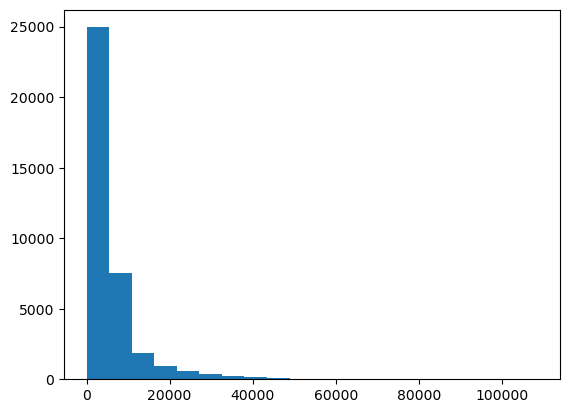

In [60]:
plt.hist(df_policy['quote'], bins = 20)

**It can be seen that the quotes are highly skewed towards the right. We'll perform binning to convert quotes into categories.** 

In [61]:
df_policy['quote'].quantile(np.linspace(.1,1,9,0))

0.1     1378.0
0.2     1983.0
0.3     2509.2
0.4     3083.0
0.5     3744.0
0.6     4570.0
0.7     5736.8
0.8     7543.2
0.9    12123.4
Name: quote, dtype: float64

In [62]:
bins = [0,2500,5000,7500,10000,200000]
labels = ['Very Low','Low','Medium','High','Very High']
df_policy['quote_range'] = pd.cut(df_policy['quote'], bins = bins, labels = labels)
df_policy.head(10)

,Unnamed: 0,Quote_dt,discount,Home_policy_ind,zip,state_id,county_name,Agent_cd,quoted_amt,Prior_carrier_grp,credit_score,Cov_package_type,CAT_zone,policy_id,number_drivers,num_loaned_veh,num_owned_veh,num_leased_veh,total_number_veh,convert_ind,split,primary_parking,car_no,age,age_min,age_max,ownership_type_leased,ownership_type_loaned,ownership_type_owned,color_black,color_blue,color_gray,color_other,color_red,color_silver,color_white,make_AUDI,make_BMW,make_CHEVROLET,make_HONDA,make_MERCEDES-BENZ,safty_rating,safety_min,safety_max,gender_F,gender_M,living_status_dependent,living_status_own,living_status_rent,Age Group_15-25,Age Group_26-35,Age Group_36-45,Age Group_46-55,Age Group_56-65,Age Group_65+,high_education_ind_0.0,high_education_ind_1.0,quote,quote_range
0,1,28-01-2015,Yes,Y,10465.0,NY,0,15973623.0,"$5,153",0,613.0,High,2.0,policy_87209,2,1,2,0,3,0,Train,home/driveway,4,5.25,3.0,7.0,0,2,2,0,0,1,1,0,1,1,0,2,0,0,2,74.000000,70.0,78.0,1,1,0,0,2,0,0,1,0,1,0,1,1,5153.0,Medium
1,3,03-09-2018,No,N,11548.0,NY,0,32759856.0,"$3,090",0,631.0,Medium,2.0,policy_91413,2,1,2,1,4,0,Train,unknown,4,7.00,6.0,8.0,0,2,2,0,0,0,2,0,0,2,1,1,0,0,2,70.000000,61.0,79.0,1,1,0,0,2,0,0,1,1,0,0,1,1,3090.0,Low
2,5,18-05-2016,No,N,14622.0,NY,0,15675431.0,"$14,917",Carrier_3,602.0,Medium,4.0,policy_71845,2,0,1,2,3,0,Train,unknown,4,4.50,4.0,5.0,0,1,3,0,1,0,1,1,0,1,0,2,0,0,1,81.500000,69.0,94.0,1,1,0,2,0,0,0,1,0,0,1,0,2,14917.0,Very High
3,6,17-11-2016,No,N,32811.0,FL,0,91762319.0,"$4,620",0,704.0,High,1.0,policy_29027,1,2,2,0,4,0,Train,parking garage,5,6.00,4.0,10.0,1,2,2,0,0,1,1,0,3,0,1,3,0,0,1,66.000000,66.0,66.0,1,0,1,0,0,1,0,0,0,0,0,1,0,4620.0,Low
4,7,04-07-2017,No,N,10306.0,NY,0,97388179.0,"$11,470",0,611.0,High,4.0,policy_75562,4,2,2,2,6,0,Train,home/driveway,3,7.00,6.0,8.0,0,1,2,0,0,0,0,0,2,1,0,0,1,1,0,74.250000,54.0,83.0,3,1,3,1,0,3,0,1,0,0,0,4,0,11470.0,Very High
5,11,25-12-2017,No,N,55125.0,MN,0,59705446.0,"$2,566",0,668.0,Medium,2.0,policy_37837,1,1,1,0,2,0,Train,unknown,5,4.80,2.0,8.0,0,2,3,0,1,1,0,0,0,2,0,0,1,2,0,76.000000,76.0,76.0,1,0,0,1,0,0,0,0,1,0,0,1,0,2566.0,Low
6,12,22-11-2018,No,N,33136.0,FL,0,37520067.0,"$1,779",0,772.0,Low,2.0,policy_10225,3,2,1,1,4,0,Train,unknown,2,3.50,2.0,5.0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,71.666667,60.0,89.0,1,2,1,2,0,1,1,0,1,0,0,2,1,1779.0,Very Low
7,13,30-03-2015,Yes,Y,7666.0,NJ,0,84058252.0,"$4,597",0,568.0,Low,4.0,policy_49495,4,0,2,1,3,0,Train,unknown,2,6.50,5.0,8.0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,77.000000,62.0,91.0,1,3,2,2,0,2,1,0,1,0,0,2,1,4597.0,Low
8,14,11-11-2016,No,N,33143.0,FL,0,19952087.0,"$2,196",0,621.0,High,5.0,policy_20593,2,1,2,2,5,0,Train,unknown,4,4.00,1.0,9.0,1,2,1,0,1,1,1,0,0,1,0,2,0,0,2,68.000000,40.0,96.0,0,2,0,2,0,0,1,0,0,1,0,1,1,2196.0,Very Low
9,16,07-10-2018,No,N,7676.0,NJ,0,53860167.0,"$1,636",0,723.0,Low,2.0,policy_45595,1,1,1,0,2,1,Train,unknown,2,3.00,2.0,4.0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,61.000000,61.0,61.0,0,1,0,0,1,0,0,1,0,0,0,0,1,1636.0,Very Low


In [63]:
# CHecking the distribution of data into quote categories
df_policy['quote_range'].value_counts()

Low          12690
Very Low     10975
Medium        5685
Very High     4809
High          2616
Name: quote_range, dtype: int64

In [64]:
# Checking conversion percentage in the quote categories
pd.crosstab(df_policy['quote_range'], df_policy['convert_ind'], normalize='index') * 100

convert_ind,0,1
quote_range,,
Very Low,86.150342,13.849658
Low,88.045705,11.954295
Medium,89.709763,10.290237
High,91.896024,8.103976
Very High,94.198378,5.801622


**We can see that higher quotes have higher conversion rates.**

(array([1.000e+00, 1.000e+00, 4.000e+00, 4.000e+00, 1.500e+01, 1.900e+01,
        4.500e+01, 2.190e+02, 8.280e+02, 1.994e+03, 4.269e+03, 7.449e+03,
        8.274e+03, 6.305e+03, 3.523e+03, 1.881e+03, 1.187e+03, 6.010e+02,
        1.450e+02, 1.100e+01]),
 array([ 2.7080502 ,  3.15242271,  3.59679522,  4.04116772,  4.48554023,
         4.92991274,  5.37428525,  5.81865775,  6.26303026,  6.70740277,
         7.15177527,  7.59614778,  8.04052029,  8.4848928 ,  8.9292653 ,
         9.37363781,  9.81801032, 10.26238283, 10.70675533, 11.15112784,
        11.59550035]),
 <BarContainer object of 20 artists>)

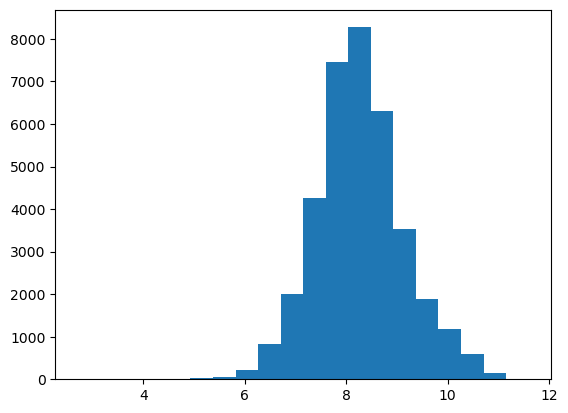

In [65]:
# Skewness can also be removed by creating a log quote column
plt.hist(np.log(df_policy['quote']), bins = 20)

In [66]:
df_policy['log_quote'] = np.log(df_policy['quote'])

In [67]:
# Checking data distribution across Carrier Groups
df_policy['Prior_carrier_grp'].value_counts()

0            26636
Carrier_3     3763
Carrier_8     3319
Carrier_7     3144
Name: Prior_carrier_grp, dtype: int64

In [68]:
# Checking data distribution for different coverage types
df_policy['Cov_package_type'].value_counts()

Medium    13964
High      12282
Low       10023
Name: Cov_package_type, dtype: int64

In [69]:
# Checking data distribution across CAT zones
df_policy['CAT_zone'].value_counts()

2.0    8778
1.0    8212
5.0    7237
3.0    6414
4.0    6040
Name: CAT_zone, dtype: int64

In [70]:
# Checking data distribution across parking types
df_policy['primary_parking'].value_counts()

unknown           25828
home/driveway      5544
parking garage     3600
street             1890
Name: primary_parking, dtype: int64

**Checking data consistency for number of drivers across the two datasets provided.**

In [71]:
df_policy['total_drivers'] = df_policy['gender_F']+df_policy['gender_M']

In [72]:
len(df_policy)

36862

In [73]:
len(df_policy[df_policy['number_drivers'] == df_policy['total_drivers']])

36825

In [74]:
# Checking no. of males that have received policy quotes
df_policy['gender_F'].sum()

39006

In [75]:
# Checking no. of females that have received policy quotes
df_policy['gender_M'].sum()

40563

In [76]:
# Checking consistency for max credit score
df_policy['credit_score'].max()

850.0

(array([   19.,    59.,   103.,   344.,  1009.,  3545.,  9257., 12579.,
         8055.,  1879.]),
 array([ -6. ,   4.6,  15.2,  25.8,  36.4,  47. ,  57.6,  68.2,  78.8,
         89.4, 100. ]),
 <BarContainer object of 10 artists>)

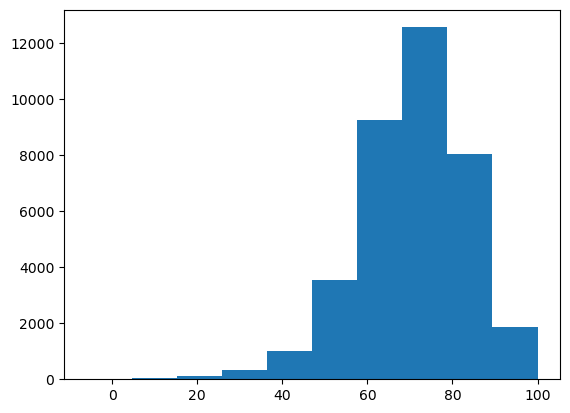

In [77]:
# Checking distribtuion of data by safety_rating
plt.hist(df_policy['safty_rating'],bins=10)

In [78]:
df_policy['safty_rating'].quantile(np.linspace(.2,1,4,0))

0.2    61.000000
0.4    68.520000
0.6    74.500000
0.8    81.333333
Name: safty_rating, dtype: float64

**Safety rating attribute is divided into 5 categories approximated from the distribution of safety ratings.**

In [79]:
bins = [0,59,69,79,89,100]
labels = ['Very Low','Low','Medium','High','Very High']
df_policy['safety_rating'] = pd.cut(df_policy['safty_rating'], bins = bins, labels = labels)
df_policy.head(10)

,Unnamed: 0,Quote_dt,discount,Home_policy_ind,zip,state_id,county_name,Agent_cd,quoted_amt,Prior_carrier_grp,credit_score,Cov_package_type,CAT_zone,policy_id,number_drivers,num_loaned_veh,num_owned_veh,num_leased_veh,total_number_veh,convert_ind,split,primary_parking,car_no,age,age_min,age_max,ownership_type_leased,ownership_type_loaned,ownership_type_owned,color_black,color_blue,color_gray,color_other,color_red,color_silver,color_white,make_AUDI,make_BMW,make_CHEVROLET,make_HONDA,make_MERCEDES-BENZ,safty_rating,safety_min,safety_max,gender_F,gender_M,living_status_dependent,living_status_own,living_status_rent,Age Group_15-25,Age Group_26-35,Age Group_36-45,Age Group_46-55,Age Group_56-65,Age Group_65+,high_education_ind_0.0,high_education_ind_1.0,quote,quote_range,log_quote,total_drivers,safety_rating
0,1,28-01-2015,Yes,Y,10465.0,NY,0,15973623.0,"$5,153",0,613.0,High,2.0,policy_87209,2,1,2,0,3,0,Train,home/driveway,4,5.25,3.0,7.0,0,2,2,0,0,1,1,0,1,1,0,2,0,0,2,74.000000,70.0,78.0,1,1,0,0,2,0,0,1,0,1,0,1,1,5153.0,Medium,8.547334,2,Medium
1,3,03-09-2018,No,N,11548.0,NY,0,32759856.0,"$3,090",0,631.0,Medium,2.0,policy_91413,2,1,2,1,4,0,Train,unknown,4,7.00,6.0,8.0,0,2,2,0,0,0,2,0,0,2,1,1,0,0,2,70.000000,61.0,79.0,1,1,0,0,2,0,0,1,1,0,0,1,1,3090.0,Low,8.035926,2,Medium
2,5,18-05-2016,No,N,14622.0,NY,0,15675431.0,"$14,917",Carrier_3,602.0,Medium,4.0,policy_71845,2,0,1,2,3,0,Train,unknown,4,4.50,4.0,5.0,0,1,3,0,1,0,1,1,0,1,0,2,0,0,1,81.500000,69.0,94.0,1,1,0,2,0,0,0,1,0,0,1,0,2,14917.0,Very High,9.610257,2,High
3,6,17-11-2016,No,N,32811.0,FL,0,91762319.0,"$4,620",0,704.0,High,1.0,policy_29027,1,2,2,0,4,0,Train,parking garage,5,6.00,4.0,10.0,1,2,2,0,0,1,1,0,3,0,1,3,0,0,1,66.000000,66.0,66.0,1,0,1,0,0,1,0,0,0,0,0,1,0,4620.0,Low,8.438150,1,Low
4,7,04-07-2017,No,N,10306.0,NY,0,97388179.0,"$11,470",0,611.0,High,4.0,policy_75562,4,2,2,2,6,0,Train,home/driveway,3,7.00,6.0,8.0,0,1,2,0,0,0,0,0,2,1,0,0,1,1,0,74.250000,54.0,83.0,3,1,3,1,0,3,0,1,0,0,0,4,0,11470.0,Very High,9.347490,4,Medium
5,11,25-12-2017,No,N,55125.0,MN,0,59705446.0,"$2,566",0,668.0,Medium,2.0,policy_37837,1,1,1,0,2,0,Train,unknown,5,4.80,2.0,8.0,0,2,3,0,1,1,0,0,0,2,0,0,1,2,0,76.000000,76.0,76.0,1,0,0,1,0,0,0,0,1,0,0,1,0,2566.0,Low,7.850104,1,Medium
6,12,22-11-2018,No,N,33136.0,FL,0,37520067.0,"$1,779",0,772.0,Low,2.0,policy_10225,3,2,1,1,4,0,Train,unknown,2,3.50,2.0,5.0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,71.666667,60.0,89.0,1,2,1,2,0,1,1,0,1,0,0,2,1,1779.0,Very Low,7.483807,3,Medium
7,13,30-03-2015,Yes,Y,7666.0,NJ,0,84058252.0,"$4,597",0,568.0,Low,4.0,policy_49495,4,0,2,1,3,0,Train,unknown,2,6.50,5.0,8.0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,77.000000,62.0,91.0,1,3,2,2,0,2,1,0,1,0,0,2,1,4597.0,Low,8.433159,4,Medium
8,14,11-11-2016,No,N,33143.0,FL,0,19952087.0,"$2,196",0,621.0,High,5.0,policy_20593,2,1,2,2,5,0,Train,unknown,4,4.00,1.0,9.0,1,2,1,0,1,1,1,0,0,1,0,2,0,0,2,68.000000,40.0,96.0,0,2,0,2,0,0,1,0,0,1,0,1,1,2196.0,Very Low,7.694393,2,Low
9,16,07-10-2018,No,N,7676.0,NJ,0,53860167.0,"$1,636",0,723.0,Low,2.0,policy_45595,1,1,1,0,2,1,Train,unknown,2,3.00,2.0,4.0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,61.000000,61.0,61.0,0,1,0,0,1,0,0,1,0,0,0,0,1,1636.0,Very Low,7.400010,1,Low


In [80]:
df_policy['safety_rating'].value_counts()

Medium       12004
Low           9471
High          7415
Very Low      6076
Very High     1880
Name: safety_rating, dtype: int64

---------------------------------------
## EDA
---------------------------------------

**First, we check for bivariate analysis and look how the features affect the target variable independently.**

[Text(0, 0, '681'),
 Text(0, 0, '920'),
 Text(0, 0, '1357'),
 Text(0, 0, '926'),
 Text(0, 0, '231')]

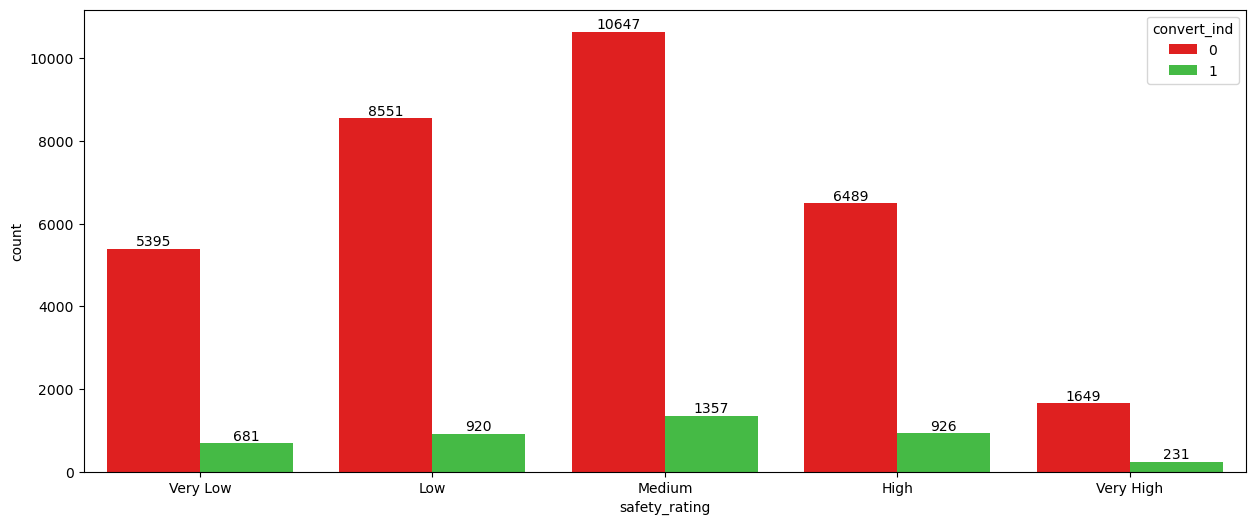

In [81]:
# Plotting safety rating categories vs conversion indicator
fig, ax = plt.subplots(figsize = (15,6))
sns.countplot(x='safety_rating', hue='convert_ind', data=df_policy, palette = ['Red','limegreen'])
ax.bar_label(container=ax.containers[0])
ax.bar_label(container=ax.containers[1])

In [82]:
# Tabulating percentage conversions by safety rating categories
pd.crosstab(df_policy['safety_rating'], df_policy['convert_ind'], normalize='index') * 100

convert_ind,0,1
safety_rating,,
Very Low,88.791968,11.208032
Low,90.286137,9.713863
Medium,88.695435,11.304565
High,87.511800,12.488200
Very High,87.712766,12.287234


**The conversion rate is highest for people with High and Very High safety rating, while maximum policies are sold to people in Medium safety rating category. The company sells extremely low number of policies to people with very high safety ratings.**

(array([  10.,  158., 1708., 4646., 6114., 8753., 6943., 4814., 3197.,
         295.]),
 array([369. , 417.1, 465.2, 513.3, 561.4, 609.5, 657.6, 705.7, 753.8,
        801.9, 850. ]),
 <BarContainer object of 10 artists>)

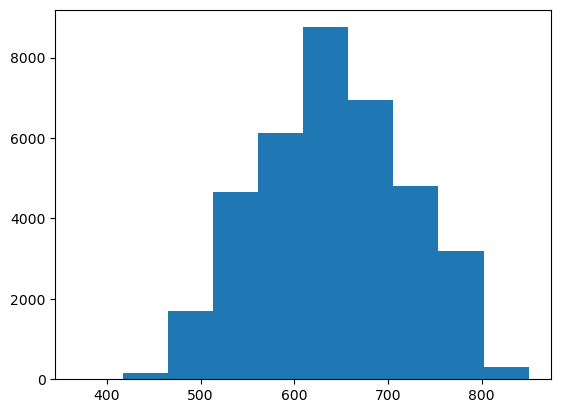

In [83]:
plt.hist(df_policy['credit_score'],bins=10)

In [84]:
df_policy['credit_score'].quantile(np.linspace(.33,1,2,0))

0.330    606.0
0.665    675.0
Name: credit_score, dtype: float64

In [85]:
bins = [0,500,600,700,800,850]
labels = ['Very Low','Low','Medium','High','Very High']
df_policy['credit_score_range'] = pd.cut(df_policy['credit_score'], bins = bins, labels = labels)

In [86]:
df_policy['credit_score_range'].value_counts()

Medium       16445
Low          10219
High          8518
Very Low      1143
Very High      313
Name: credit_score_range, dtype: int64

[Text(0, 0, '80'),
 Text(0, 0, '862'),
 Text(0, 0, '1902'),
 Text(0, 0, '1195'),
 Text(0, 0, '48')]

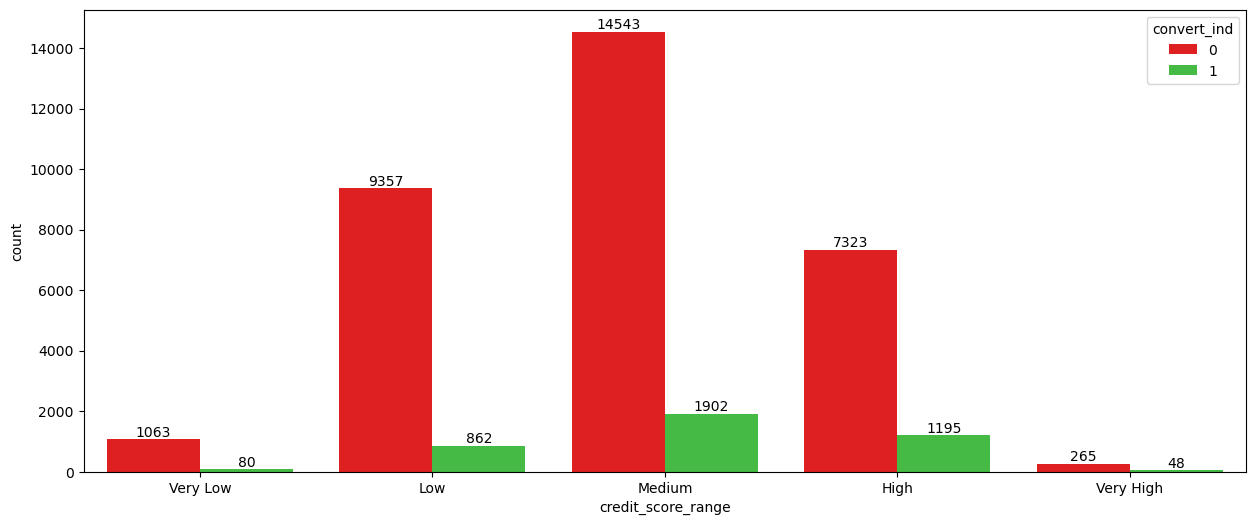

In [87]:
# Plotting credit score categories vs conversion indicator
fig, ax = plt.subplots(figsize = (15,6))
sns.countplot(x='credit_score_range', hue='convert_ind', data=df_policy, palette = ['Red','limegreen'])
ax.bar_label(container=ax.containers[0])
ax.bar_label(container=ax.containers[1])

In [88]:
# Tabulating percentage conversions by credit score categories
pd.crosstab(df_policy['credit_score_range'], df_policy['convert_ind'], normalize='index') * 100

convert_ind,0,1
credit_score_range,,
Very Low,93.000875,6.999125
Low,91.564732,8.435268
Medium,88.434175,11.565825
High,85.970885,14.029115
Very High,84.664537,15.335463


**The conversion rate is highest for people with High and Very High credit scores, while maximum policies are sold to people in Medium credit score category. The company sells extremely low number of policies to people with very high credit scores.**

Text(0, 0.5, 'age_of_cars')

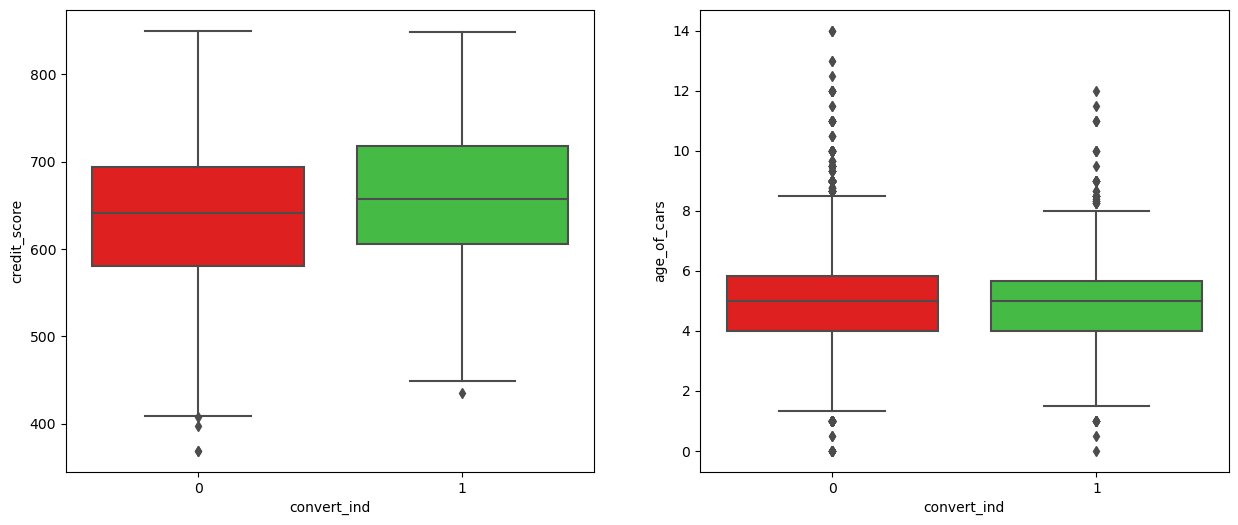

In [89]:
# Plotting box plots of credit score and car age vs conversion indicator

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (15,6))

sns.boxplot(x='convert_ind', y='credit_score', data=df_policy, palette = ['Red','limegreen'], ax = ax1)
sns.boxplot(x='convert_ind', y='age', data=df_policy, palette = ['Red','limegreen'], ax = ax2)
ax2.set_ylabel('age_of_cars')


**Car age doesn't seems to differ much, while credit scores seem to be higher for those that convert.**

In [90]:
pd.crosstab(df_policy['age'], df_policy['convert_ind'])

convert_ind,0,1
age,,
0.000000,17,1
0.500000,2,1
1.000000,86,10
1.333333,8,0
1.500000,51,2
1.666667,18,2
1.750000,4,0
1.800000,2,0
2.000000,379,50


Text(0, 0.5, 'max_age_of_cars')

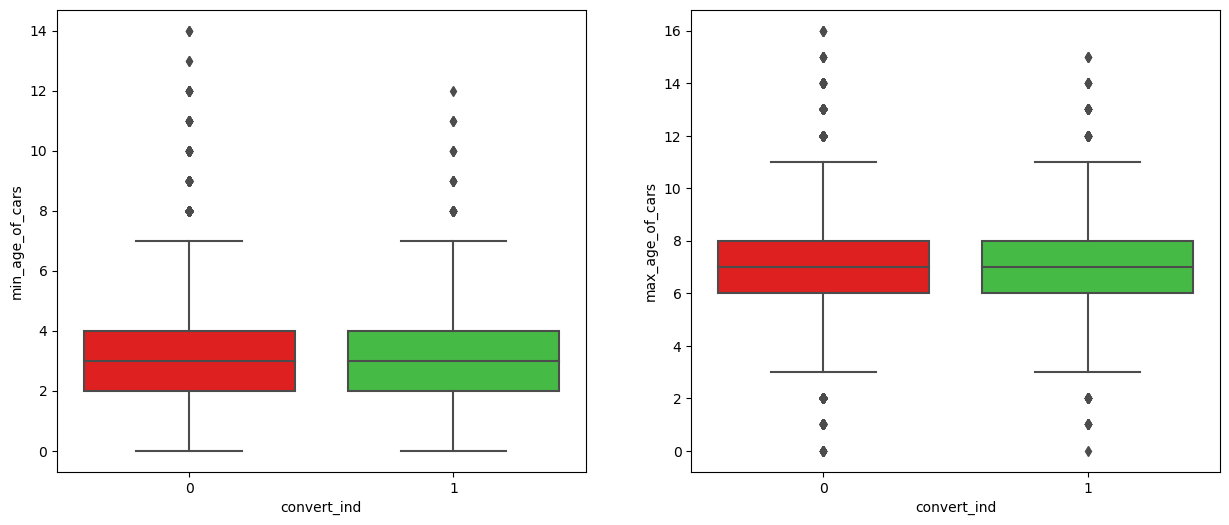

In [91]:
# Plotting boxplots of min and max age of cars vs conversion indicator
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (15,6))

sns.boxplot(x='convert_ind', y='age_min', data=df_policy, palette = ['Red','limegreen'], ax = ax1)
sns.boxplot(x='convert_ind', y='age_max', data=df_policy, palette = ['Red','limegreen'], ax = ax2)
ax1.set_ylabel('min_age_of_cars')
ax2.set_ylabel('max_age_of_cars')

**There doesn't seem to be any difference in conversion by min and max age of cars.**

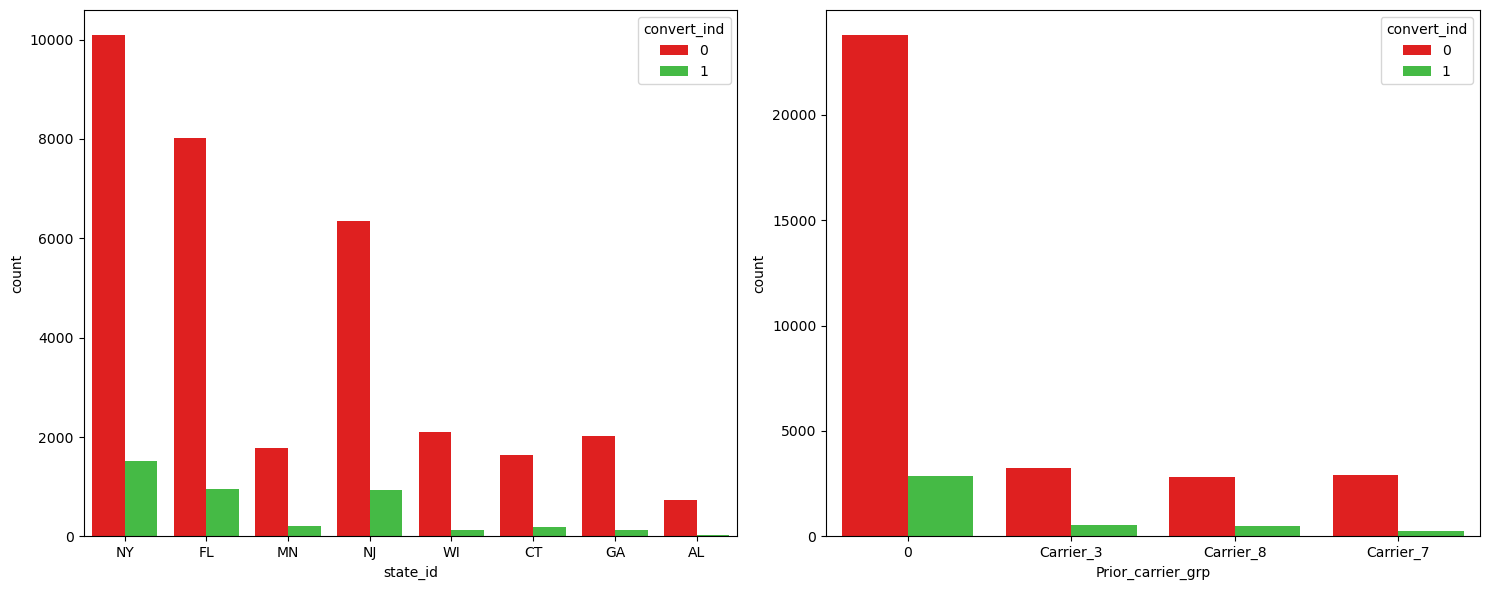

In [92]:
# Plotting state id and prior carrier group vs conversion indicator

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (15,6))
sns.countplot(x='state_id', hue='convert_ind', data=df_policy, ax = ax1, palette = ['Red','limegreen'])
sns.countplot(x='Prior_carrier_grp', hue='convert_ind', data=df_policy, ax = ax2, palette = ['Red','limegreen'])
fig.tight_layout()

In [93]:
# Tabulating percentage conversions by state ids
pd.crosstab(df_policy['state_id'], df_policy['convert_ind'], normalize='index') * 100

convert_ind,0,1
state_id,,
AL,95.501285,4.498715
CT,90.021930,9.978070
FL,89.412027,10.587973
GA,93.543892,6.456108
MN,89.093625,10.906375
NJ,87.137955,12.862045
NY,86.907838,13.092162
WI,93.886658,6.113342


**NY seems to have highest converion rate and it is the state with highest number of policies being quoted and sold by the company. NY, FL and NJ are the three states that cover a large proportion of the policies quoted and sold by the company.**

In [94]:
# Tabulating percentage conversions by prior carrier groups
pd.crosstab(df_policy['Prior_carrier_grp'], df_policy['convert_ind'], normalize='index') * 100

convert_ind,0,1
Prior_carrier_grp,,
0,89.255143,10.744857
Carrier_3,86.021791,13.978209
Carrier_7,92.080153,7.919847
Carrier_8,85.507683,14.492317


**People with Prior Carrier Group 3 and 8 seem to have a higher conversion rate when compared with people having other prior carriers.**

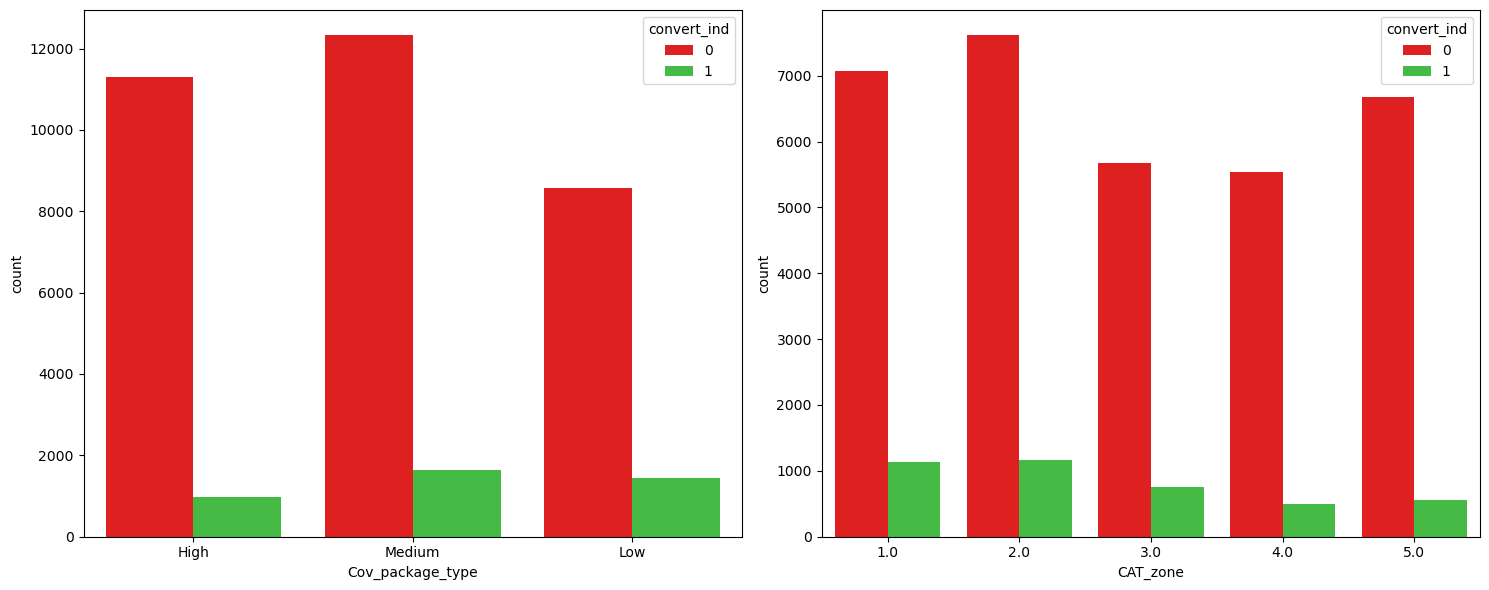

In [95]:
#Plotting coverage package type and CAT Zone vs conversion indicator

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (15,6))
sns.countplot(x='Cov_package_type', hue='convert_ind', data=df_policy, ax = ax1, palette = ['Red','limegreen'])
sns.countplot(x='CAT_zone', hue='convert_ind', data=df_policy, ax = ax2, palette = ['Red','limegreen'])
fig.tight_layout()

In [96]:
# Tabulating percentage conversions by coverage package type
pd.crosstab(df_policy['Cov_package_type'], df_policy['convert_ind'], normalize='index') * 100

convert_ind,0,1
Cov_package_type,,
High,92.053411,7.946589
Low,85.553228,14.446772
Medium,88.319966,11.680034


**Conversions are highest with low coverage type policies, and the company sells the least number of policies in Low coverage type amongst the three, and highest in the Medium coverage type.**

In [97]:
# Tabulating percentage conversions by CAT Zones
pd.crosstab(df_policy['CAT_zone'], df_policy['convert_ind'], normalize='index') * 100

convert_ind,0,1
CAT_zone,,
1.0,86.178763,13.821237
2.0,86.773753,13.226247
3.0,88.369192,11.630808
4.0,91.771523,8.228477
5.0,92.234351,7.765649


**For lower CAT zones, the conversion percentages are higher, while the maximum policies are quoted in CAT zone 2, and the lesat in CAT zone 4.**

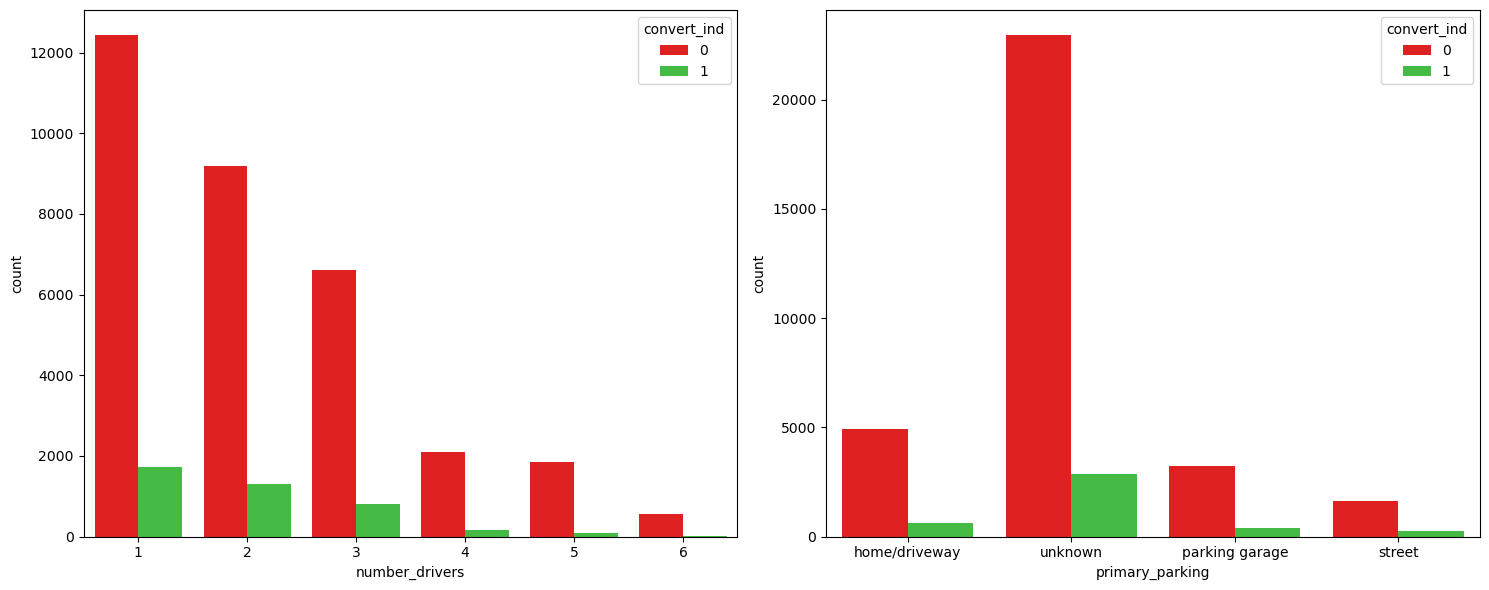

In [98]:
# Plotting number of drivers and total number of vehicles vs conversion indicator

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (15,6))
sns.countplot(x='number_drivers', hue='convert_ind', data=df_policy, ax = ax1, palette = ['Red','limegreen'])
sns.countplot(x='primary_parking', hue='convert_ind', data=df_policy, ax = ax2, palette = ['Red','limegreen'])
fig.tight_layout()

In [99]:
# Tabulating percentage conversions by number of drivers
pd.crosstab(df_policy['number_drivers'], df_policy['convert_ind'], normalize='index') * 100

convert_ind,0,1
number_drivers,,
1,87.782326,12.217674
2,87.535680,12.464320
3,89.086740,10.913260
4,93.108048,6.891952
5,95.125705,4.874295
6,96.858639,3.141361


**Conversions are highest when number of drivers are fewer in a policy, and the company sells the maximum policies where there are fewer drivers.**

In [100]:
# Tabulating percentage conversions by parking type
pd.crosstab(df_policy['primary_parking'], df_policy['convert_ind'], normalize='index') * 100

convert_ind,0,1
primary_parking,,
home/driveway,89.105339,10.894661
parking garage,89.222222,10.777778
street,86.507937,13.492063
unknown,88.884157,11.115843


**Nothing much can be inferred from the parking types.**

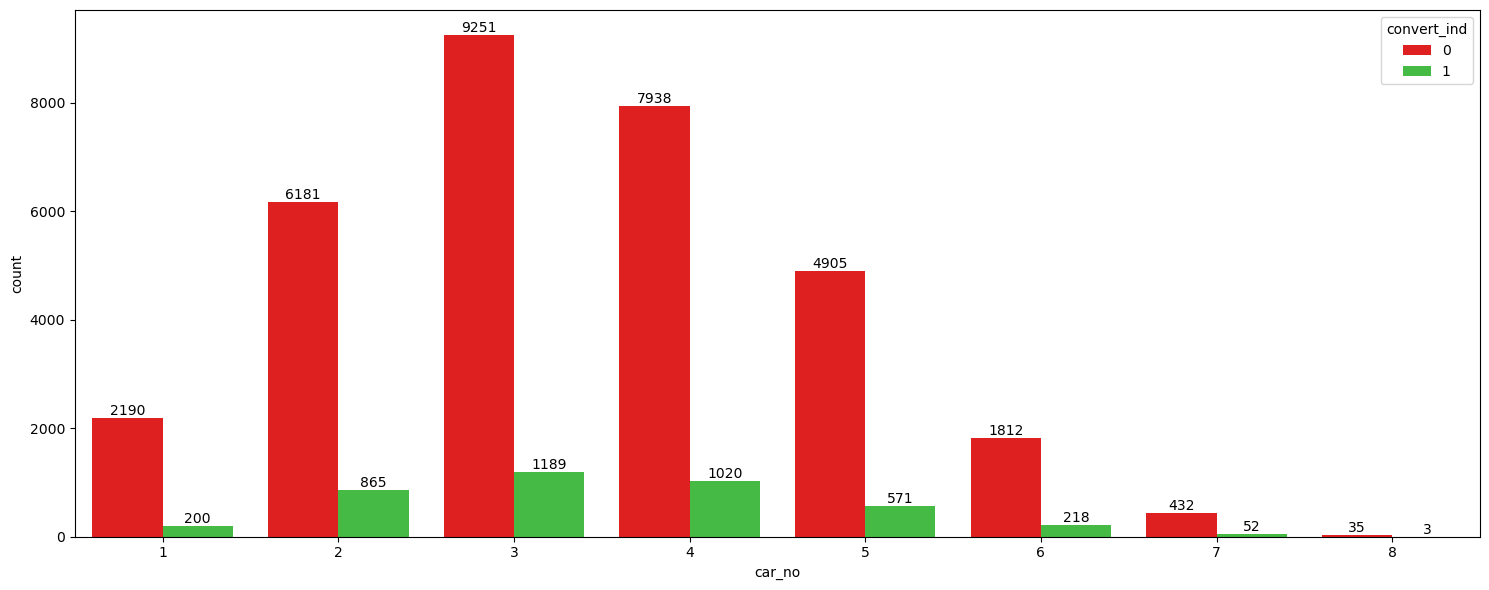

In [101]:
# Plotting no. of cars in policy by conversion type

fig, ax = plt.subplots(figsize = (15,6))
sns.countplot(x='car_no', hue='convert_ind', data=df_policy, ax = ax, palette = ['Red','limegreen'])
ax.bar_label(container=ax.containers[0])
ax.bar_label(container=ax.containers[1])
fig.tight_layout()

In [102]:
# Tabulating percentage conversions by no. of cars in policy
pd.crosstab(df_policy['car_no'], df_policy['convert_ind'], normalize='index') * 100

convert_ind,0,1
car_no,,
1,91.631799,8.368201
2,87.723531,12.276469
3,88.611111,11.388889
4,88.613530,11.386470
5,89.572681,10.427319
6,89.261084,10.738916
7,89.256198,10.743802
8,92.105263,7.894737


**The conversion rates are highest when there 2,3 or 4 cars in a policy, and the maximum policies are quoted and sold to families with 3 or 4 cars.**

#### Checking Correlation 

In [103]:
# Checking the datatypes
df_policy.dtypes

Unnamed: 0                    int64
Quote_dt                     object
discount                     object
Home_policy_ind              object
zip                         float64
state_id                     object
county_name                  object
Agent_cd                    float64
quoted_amt                   object
Prior_carrier_grp            object
credit_score                float64
Cov_package_type             object
CAT_zone                    float64
policy_id                    object
number_drivers                int64
num_loaned_veh                int64
num_owned_veh                 int64
num_leased_veh                int64
total_number_veh              int64
convert_ind                   int64
split                        object
primary_parking              object
car_no                        int64
age                         float64
age_min                     float64
age_max                     float64
ownership_type_leased         uint8
ownership_type_loaned       

In [104]:
# Getting just the numerical features
numerical = df_policy.select_dtypes(include=['int64','float64','Int64'])[:]
numerical

,Unnamed: 0,zip,Agent_cd,credit_score,CAT_zone,number_drivers,num_loaned_veh,num_owned_veh,num_leased_veh,total_number_veh,convert_ind,car_no,age,age_min,age_max,safty_rating,safety_min,safety_max,quote,log_quote
0,1,10465.0,15973623.0,613.0,2.0,2,1,2,0,3,0,4,5.25,3.0,7.0,74.00,70.0,78.0,5153.0,8.547334
1,3,11548.0,32759856.0,631.0,2.0,2,1,2,1,4,0,4,7.00,6.0,8.0,70.00,61.0,79.0,3090.0,8.035926
2,5,14622.0,15675431.0,602.0,4.0,2,0,1,2,3,0,4,4.50,4.0,5.0,81.50,69.0,94.0,14917.0,9.610257
3,6,32811.0,91762319.0,704.0,1.0,1,2,2,0,4,0,5,6.00,4.0,10.0,66.00,66.0,66.0,4620.0,8.438150
4,7,10306.0,97388179.0,611.0,4.0,4,2,2,2,6,0,3,7.00,6.0,8.0,74.25,54.0,83.0,11470.0,9.347490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36857,49158,32601.0,61229929.0,590.0,4.0,1,2,2,0,4,0,4,5.00,3.0,7.0,90.00,90.0,90.0,4042.0,8.304495
36858,49159,11553.0,33958256.0,688.0,2.0,2,2,2,0,4,0,4,6.25,4.0,8.0,73.50,59.0,88.0,5743.0,8.655737
36859,49160,33027.0,92637408.0,637.0,2.0,1,1,3,1,5,0,2,7.00,7.0,7.0,39.00,39.0,39.0,2230.0,7.709757
36860,49161,11561.0,33958256.0,581.0,4.0,2,2,2,0,4,1,5,4.80,2.0,8.0,78.00,68.0,88.0,8428.0,9.039315


In [105]:
numerical = numerical.drop(["zip","Agent_cd"], axis = 1)
numerical.dtypes

Unnamed: 0            int64
credit_score        float64
CAT_zone            float64
number_drivers        int64
num_loaned_veh        int64
num_owned_veh         int64
num_leased_veh        int64
total_number_veh      int64
convert_ind           int64
car_no                int64
age                 float64
age_min             float64
age_max             float64
safty_rating        float64
safety_min          float64
safety_max          float64
quote               float64
log_quote           float64
dtype: object

In [106]:
# Creating correlation matrix
correlation = numerical.dropna().corr()
correlation

,Unnamed: 0,credit_score,CAT_zone,number_drivers,num_loaned_veh,num_owned_veh,num_leased_veh,total_number_veh,convert_ind,car_no,age,age_min,age_max,safty_rating,safety_min,safety_max,quote,log_quote
Unnamed: 0,1.000000,0.000984,0.002536,0.004584,0.002867,-0.003182,-0.013169,-0.006388,0.000859,-0.006681,-0.007891,-0.003311,-0.006899,0.007341,0.001512,0.008805,0.000667,-0.002214
credit_score,0.000984,1.000000,-0.246360,0.010131,0.009434,-0.002339,0.000291,0.005245,0.072391,-0.004828,0.004160,0.005869,0.000963,-0.002822,-0.007293,0.002197,-0.552545,-0.772746
CAT_zone,0.002536,-0.246360,1.000000,-0.010495,-0.001070,0.010568,0.001413,0.005731,-0.077166,0.010103,0.005533,0.001241,0.005141,-0.001532,0.001410,-0.004254,0.198996,0.251992
number_drivers,0.004584,0.010131,-0.010495,1.000000,0.005387,0.003813,-0.002505,0.004457,-0.062884,-0.062441,-0.001213,0.027024,-0.030593,-0.160588,-0.501435,0.300615,-0.012994,-0.008986
num_loaned_veh,0.002867,0.009434,-0.001070,0.005387,1.000000,0.001837,-0.001502,0.675597,0.004189,0.001148,-0.001635,0.002428,-0.001122,0.005685,0.001444,0.007605,-0.000678,-0.003500
num_owned_veh,-0.003182,-0.002339,0.010568,0.003813,0.001837,1.000000,-0.005172,0.542402,0.003138,-0.005102,0.006660,0.003335,0.006328,-0.003238,-0.001806,-0.005559,0.003741,0.002488
num_leased_veh,-0.013169,0.000291,0.001413,-0.002505,-0.001502,-0.005172,1.000000,0.496892,-0.000723,-0.007539,0.001203,-0.001987,0.003915,0.005557,0.007575,-0.000125,0.004800,0.003782
total_number_veh,-0.006388,0.005245,0.005731,0.004457,0.675597,0.542402,0.496892,1.000000,0.004173,-0.005774,0.003119,0.002459,0.004643,0.004862,0.003786,0.002051,0.003979,0.000883
convert_ind,0.000859,0.072391,-0.077166,-0.062884,0.004189,0.003138,-0.000723,0.004173,1.000000,-0.002912,-0.015802,-0.019038,-0.001953,0.016500,0.033610,-0.007215,-0.075972,-0.083635
car_no,-0.006681,-0.004828,0.010103,-0.062441,0.001148,-0.005102,-0.007539,-0.005774,-0.002912,1.000000,-0.012485,-0.372536,0.332493,0.013806,0.035880,-0.016328,0.007589,0.008690


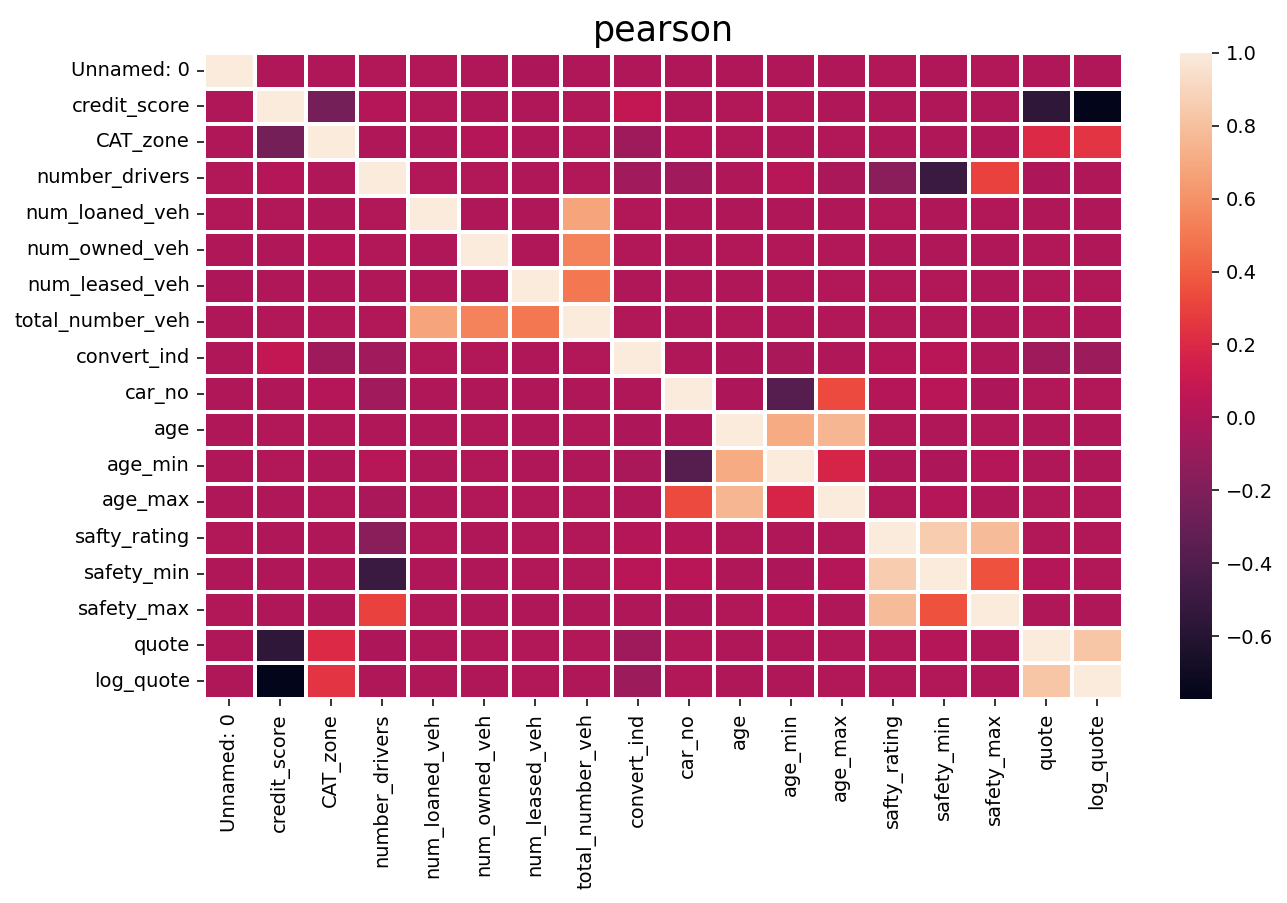

In [107]:
# plotting heatmap usill all methods for all numerical variables
plt.figure(figsize=(36,6), dpi=140)
for j,i in enumerate(['pearson']):
  plt.subplot(1,3,j+1)
  correlation = numerical.dropna().corr(method=i)
  sns.heatmap(correlation, linewidth = 2)
  plt.title(i, fontsize=18)

**We can see that there is high correlation between min car age, max car age with mean car age in policy and min safety, max safety with mean safety rating in a policy. These features have been added by us to check for some hidden trend if possible, and we will keep these for now and do not remove them from our dataset.**  

In [108]:
df_policy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36862 entries, 0 to 36861
Data columns (total 63 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Unnamed: 0               36862 non-null  int64   
 1   Quote_dt                 36862 non-null  object  
 2   discount                 36862 non-null  object  
 3   Home_policy_ind          36862 non-null  object  
 4   zip                      36510 non-null  float64 
 5   state_id                 36862 non-null  object  
 6   county_name              36862 non-null  object  
 7   Agent_cd                 32791 non-null  float64 
 8   quoted_amt               36775 non-null  object  
 9   Prior_carrier_grp        36862 non-null  object  
 10  credit_score             36638 non-null  float64 
 11  Cov_package_type         36269 non-null  object  
 12  CAT_zone                 36681 non-null  float64 
 13  policy_id                36862 non-null  object  
 14  number

In [109]:
# Dropping quoted amt, as a numerical column for same has been created, and dropping total drivers as that information is redundantq
df_policy.drop(['quoted_amt', 'total_drivers'], axis = 1, inplace = True)

---------------------------------------------
## Feature Engineering
---------------------------------------------

**We add safety range as the difference of max and min safety ratings in a policy, and car age range as the difference between the oldest and newest car in a policy.**

In [110]:
df_policy['safety_range'] = df_policy['safety_max'] - df_policy['safety_min']
df_policy['car_age_range'] = df_policy['age_max'] - df_policy['age_min']

**We will extract month, quarter and year from date to check if some insights could be obtained from these new features.**

In [111]:
df_policy['Quote_dt'] = pd.to_datetime(df_policy['Quote_dt'], infer_datetime_format = True)

In [112]:
df_policy['Quote_month'] = df_policy['Quote_dt'].dt.month
df_policy['Quote_month'].value_counts()

10    3263
11    3197
5     3164
7     3142
8     3114
3     3113
12    3096
1     3060
9     2966
4     2940
6     2934
2     2873
Name: Quote_month, dtype: int64

In [113]:
pd.crosstab(df_policy['Quote_month'], df_policy['convert_ind'], normalize='index') * 100

convert_ind,0,1
Quote_month,,
1,89.281046,10.718954
2,88.722590,11.277410
3,89.013813,10.986187
4,88.571429,11.428571
5,88.242731,11.757269
6,88.275392,11.724608
7,88.796945,11.203055
8,89.306358,10.693642
9,88.840189,11.159811


**There doesn't seems to any significant difference in month wise conversion percentage.**

In [114]:
df_policy['Quote_quarter'] = df_policy['Quote_dt'].dt.quarter
df_policy['Quote_quarter'].value_counts()

4    9556
3    9222
1    9046
2    9038
Name: Quote_quarter, dtype: int64

In [115]:
pd.crosstab(df_policy['Quote_quarter'], df_policy['convert_ind'], normalize='index') * 100

convert_ind,0,1
Quote_quarter,,
1,89.011718,10.988282
2,88.360257,11.639743
3,88.982867,11.017133
4,88.949351,11.050649


**There doesn't seems to any significant difference in quarter wise conversion percentage.**

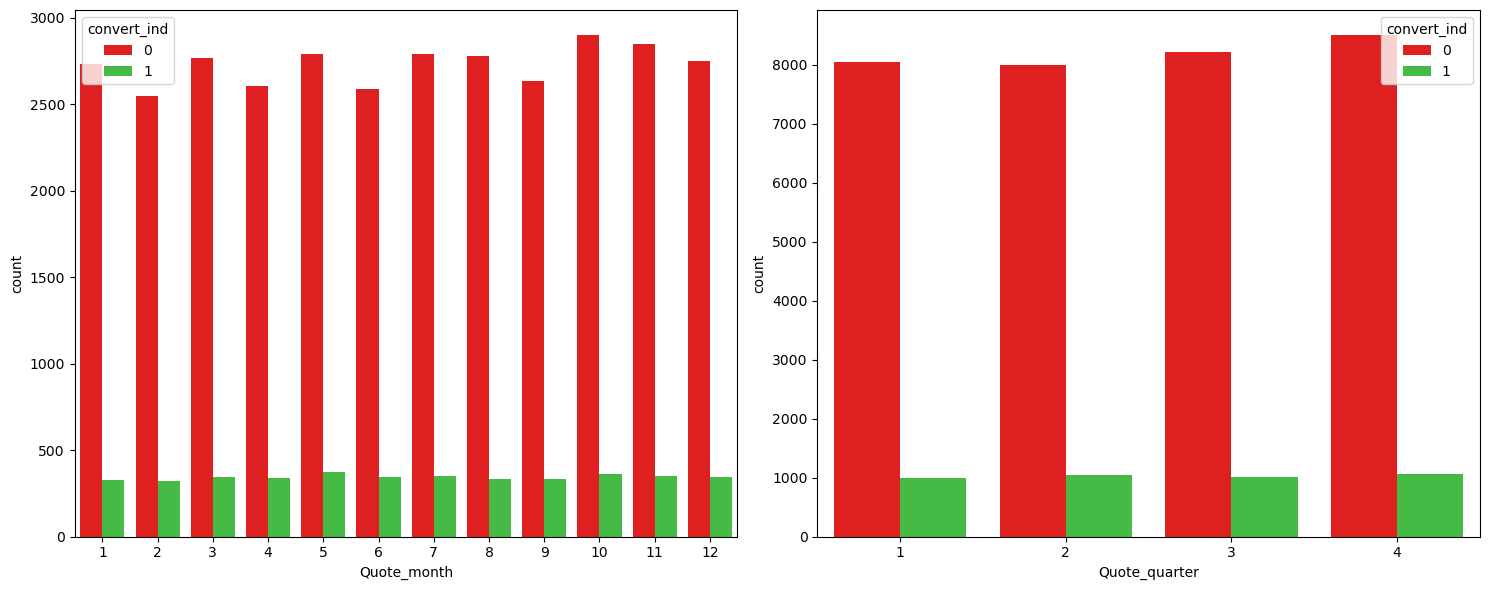

In [116]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (15,6))
sns.countplot(x='Quote_month', hue='convert_ind', data=df_policy, ax = ax1, palette = ['Red','limegreen'])
sns.countplot(x='Quote_quarter', hue='convert_ind', data=df_policy, ax = ax2, palette = ['Red','limegreen'])
fig.tight_layout()

**There doesn't seems to any significant difference in quarter wise and month wise conversion count.**

In [117]:
df_policy['Quote_year'] = df_policy['Quote_dt'].dt.year
df_policy['Quote_year'].value_counts()

2016    12142
2015    10879
2018     8575
2017     5266
Name: Quote_year, dtype: int64

In [118]:
pd.crosstab(df_policy['Quote_year'], df_policy['convert_ind'], normalize='index') * 100

convert_ind,0,1
Quote_year,,
2015,87.903300,12.096700
2016,88.840389,11.159611
2017,89.346753,10.653247
2018,89.667638,10.332362


**Converion percentages have declined from 2015 to 2018.**

[Text(0, 0, '1316'), Text(0, 0, '1355'), Text(0, 0, '561'), Text(0, 0, '886')]

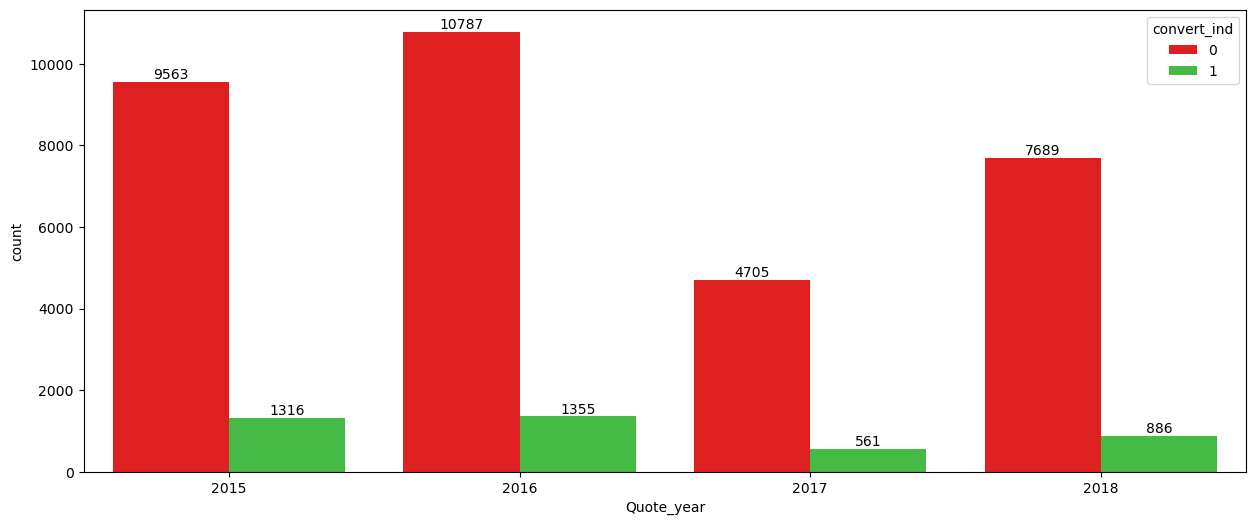

In [119]:
fig, ax = plt.subplots(figsize = (15,6))
sns.countplot(x='Quote_year', hue='convert_ind', data=df_policy, palette = ['Red','limegreen'])
ax.bar_label(container=ax.containers[0])
ax.bar_label(container=ax.containers[1])

**There were very few policies quoted in the year 2017 when compared to other years.**

In [120]:
# Creating a copy of dataset
x = df_policy

In [121]:
# Dropping redundant columns
x.drop(['split', 'Unnamed: 0', 'Quote_dt', 'zip', 'Agent_cd', 'policy_id'], axis = 1, inplace=True)

In [122]:
x.head(15)

,discount,Home_policy_ind,state_id,county_name,Prior_carrier_grp,credit_score,Cov_package_type,CAT_zone,number_drivers,num_loaned_veh,num_owned_veh,num_leased_veh,total_number_veh,convert_ind,primary_parking,car_no,age,age_min,age_max,ownership_type_leased,ownership_type_loaned,ownership_type_owned,color_black,color_blue,color_gray,color_other,color_red,color_silver,color_white,make_AUDI,make_BMW,make_CHEVROLET,make_HONDA,make_MERCEDES-BENZ,safty_rating,safety_min,safety_max,gender_F,gender_M,living_status_dependent,living_status_own,living_status_rent,Age Group_15-25,Age Group_26-35,Age Group_36-45,Age Group_46-55,Age Group_56-65,Age Group_65+,high_education_ind_0.0,high_education_ind_1.0,quote,quote_range,log_quote,safety_rating,credit_score_range,safety_range,car_age_range,Quote_month,Quote_quarter,Quote_year
0,Yes,Y,NY,0,0,613.0,High,2.0,2,1,2,0,3,0,home/driveway,4,5.250000,3.0,7.0,0,2,2,0,0,1,1,0,1,1,0,2,0,0,2,74.000000,70.0,78.0,1,1,0,0,2,0,0,1,0,1,0,1,1,5153.0,Medium,8.547334,Medium,Medium,8.0,4.0,1,1,2015
1,No,N,NY,0,0,631.0,Medium,2.0,2,1,2,1,4,0,unknown,4,7.000000,6.0,8.0,0,2,2,0,0,0,2,0,0,2,1,1,0,0,2,70.000000,61.0,79.0,1,1,0,0,2,0,0,1,1,0,0,1,1,3090.0,Low,8.035926,Medium,Medium,18.0,2.0,9,3,2018
2,No,N,NY,0,Carrier_3,602.0,Medium,4.0,2,0,1,2,3,0,unknown,4,4.500000,4.0,5.0,0,1,3,0,1,0,1,1,0,1,0,2,0,0,1,81.500000,69.0,94.0,1,1,0,2,0,0,0,1,0,0,1,0,2,14917.0,Very High,9.610257,High,Medium,25.0,1.0,5,2,2016
3,No,N,FL,0,0,704.0,High,1.0,1,2,2,0,4,0,parking garage,5,6.000000,4.0,10.0,1,2,2,0,0,1,1,0,3,0,1,3,0,0,1,66.000000,66.0,66.0,1,0,1,0,0,1,0,0,0,0,0,1,0,4620.0,Low,8.438150,Low,High,0.0,6.0,11,4,2016
4,No,N,NY,0,0,611.0,High,4.0,4,2,2,2,6,0,home/driveway,3,7.000000,6.0,8.0,0,1,2,0,0,0,0,0,2,1,0,0,1,1,0,74.250000,54.0,83.0,3,1,3,1,0,3,0,1,0,0,0,4,0,11470.0,Very High,9.347490,Medium,Medium,29.0,2.0,7,3,2017
5,No,N,MN,0,0,668.0,Medium,2.0,1,1,1,0,2,0,unknown,5,4.800000,2.0,8.0,0,2,3,0,1,1,0,0,0,2,0,0,1,2,0,76.000000,76.0,76.0,1,0,0,1,0,0,0,0,1,0,0,1,0,2566.0,Low,7.850104,Medium,Medium,0.0,6.0,12,4,2017
6,No,N,FL,0,0,772.0,Low,2.0,3,2,1,1,4,0,unknown,2,3.500000,2.0,5.0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,71.666667,60.0,89.0,1,2,1,2,0,1,1,0,1,0,0,2,1,1779.0,Very Low,7.483807,Medium,High,29.0,3.0,11,4,2018
7,Yes,Y,NJ,0,0,568.0,Low,4.0,4,0,2,1,3,0,unknown,2,6.500000,5.0,8.0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,77.000000,62.0,91.0,1,3,2,2,0,2,1,0,1,0,0,2,1,4597.0,Low,8.433159,Medium,Low,29.0,3.0,3,1,2015
8,No,N,FL,0,0,621.0,High,5.0,2,1,2,2,5,0,unknown,4,4.000000,1.0,9.0,1,2,1,0,1,1,1,0,0,1,0,2,0,0,2,68.000000,40.0,96.0,0,2,0,2,0,0,1,0,0,1,0,1,1,2196.0,Very Low,7.694393,Low,Medium,56.0,8.0,11,4,2016
9,No,N,NJ,0,0,723.0,Low,2.0,1,1,1,0,2,1,unknown,2,3.000000,2.0,4.0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,61.000000,61.0,61.0,0,1,0,0,1,0,0,1,0,0,0,0,1,1636.0,Very Low,7.400010,Low,High,0.0,2.0,10,4,2018


In [123]:
# Checking datatypes
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36862 entries, 0 to 36861
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   discount                 36862 non-null  object  
 1   Home_policy_ind          36862 non-null  object  
 2   state_id                 36862 non-null  object  
 3   county_name              36862 non-null  object  
 4   Prior_carrier_grp        36862 non-null  object  
 5   credit_score             36638 non-null  float64 
 6   Cov_package_type         36269 non-null  object  
 7   CAT_zone                 36681 non-null  float64 
 8   number_drivers           36862 non-null  int64   
 9   num_loaned_veh           36862 non-null  int64   
 10  num_owned_veh            36862 non-null  int64   
 11  num_leased_veh           36862 non-null  int64   
 12  total_number_veh         36862 non-null  int64   
 13  convert_ind              36862 non-null  int64   
 14  primar

In [124]:
# One-hot encoding for categorical features
x1 = pd.get_dummies(x, columns = ['state_id','Prior_carrier_grp', 'primary_parking', 'county_name' ])

In [125]:
x1.head(15)

,discount,Home_policy_ind,credit_score,Cov_package_type,CAT_zone,number_drivers,num_loaned_veh,num_owned_veh,num_leased_veh,total_number_veh,convert_ind,car_no,age,age_min,age_max,ownership_type_leased,ownership_type_loaned,ownership_type_owned,color_black,color_blue,color_gray,color_other,color_red,color_silver,color_white,make_AUDI,make_BMW,make_CHEVROLET,make_HONDA,make_MERCEDES-BENZ,safty_rating,safety_min,safety_max,gender_F,gender_M,living_status_dependent,living_status_own,living_status_rent,Age Group_15-25,Age Group_26-35,Age Group_36-45,Age Group_46-55,Age Group_56-65,Age Group_65+,high_education_ind_0.0,high_education_ind_1.0,quote,quote_range,log_quote,safety_rating,credit_score_range,safety_range,car_age_range,Quote_month,Quote_quarter,Quote_year,state_id_AL,state_id_CT,state_id_FL,state_id_GA,state_id_MN,state_id_NJ,state_id_NY,state_id_WI,Prior_carrier_grp_0,Prior_carrier_grp_Carrier_3,Prior_carrier_grp_Carrier_7,Prior_carrier_grp_Carrier_8,primary_parking_home/driveway,primary_parking_parking garage,primary_parking_street,primary_parking_unknown,county_name_0,county_name_Kings,county_name_New York
0,Yes,Y,613.0,High,2.0,2,1,2,0,3,0,4,5.250000,3.0,7.0,0,2,2,0,0,1,1,0,1,1,0,2,0,0,2,74.000000,70.0,78.0,1,1,0,0,2,0,0,1,0,1,0,1,1,5153.0,Medium,8.547334,Medium,Medium,8.0,4.0,1,1,2015,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0
1,No,N,631.0,Medium,2.0,2,1,2,1,4,0,4,7.000000,6.0,8.0,0,2,2,0,0,0,2,0,0,2,1,1,0,0,2,70.000000,61.0,79.0,1,1,0,0,2,0,0,1,1,0,0,1,1,3090.0,Low,8.035926,Medium,Medium,18.0,2.0,9,3,2018,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0
2,No,N,602.0,Medium,4.0,2,0,1,2,3,0,4,4.500000,4.0,5.0,0,1,3,0,1,0,1,1,0,1,0,2,0,0,1,81.500000,69.0,94.0,1,1,0,2,0,0,0,1,0,0,1,0,2,14917.0,Very High,9.610257,High,Medium,25.0,1.0,5,2,2016,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0
3,No,N,704.0,High,1.0,1,2,2,0,4,0,5,6.000000,4.0,10.0,1,2,2,0,0,1,1,0,3,0,1,3,0,0,1,66.000000,66.0,66.0,1,0,1,0,0,1,0,0,0,0,0,1,0,4620.0,Low,8.438150,Low,High,0.0,6.0,11,4,2016,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
4,No,N,611.0,High,4.0,4,2,2,2,6,0,3,7.000000,6.0,8.0,0,1,2,0,0,0,0,0,2,1,0,0,1,1,0,74.250000,54.0,83.0,3,1,3,1,0,3,0,1,0,0,0,4,0,11470.0,Very High,9.347490,Medium,Medium,29.0,2.0,7,3,2017,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0
5,No,N,668.0,Medium,2.0,1,1,1,0,2,0,5,4.800000,2.0,8.0,0,2,3,0,1,1,0,0,0,2,0,0,1,2,0,76.000000,76.0,76.0,1,0,0,1,0,0,0,0,1,0,0,1,0,2566.0,Low,7.850104,Medium,Medium,0.0,6.0,12,4,2017,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0
6,No,N,772.0,Low,2.0,3,2,1,1,4,0,2,3.500000,2.0,5.0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,71.666667,60.0,89.0,1,2,1,2,0,1,1,0,1,0,0,2,1,1779.0,Very Low,7.483807,Medium,High,29.0,3.0,11,4,2018,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0
7,Yes,Y,568.0,Low,4.0,4,0,2,1,3,0,2,6.500000,5.0,8.0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,77.000000,62.0,91.0,1,3,2,2,0,2,1,0,1,0,0,2,1,4597.0,Low,8.433159,Medium,Low,29.0,3.0,3,1,2015,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0
8,No,N,621.0,High,5.0,2,1,2,2,5,0,4,4.000000,1.0,9.0,1,2,1,0,1,1,1,0,0,1,0,2,0,0,2,68.000000,40.0,96.0,0,2,0,2,0,0,1,0,0,1,0,1,1,2196.0,Very Low,7.694393,Low,Medium,56.0,8.0,11,4,2016,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0
9,No,N,723.0,Low,2.0,1,1,1,0,2,1,2,3.000000,2.0,4.0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,61.000000,61.0,61.0,0,1,0,0,1,0,0,1,0,0,0,0,1,1636.0,Very Low,7.400010,Low,High,0.0,2.0,10,4,2018,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0


In [126]:
x1['discount'] = x1['discount'].astype('category')
x1['Home_policy_ind'] = x1['Home_policy_ind'].astype('category')
x1['Cov_package_type'] = x1['Cov_package_type'].astype('category')

In [127]:
# Creating numerical codes for categorical features so that the entire dataset is numerical and can be fed into machine learning model

x1['credit_score_range'] = x1['credit_score_range'].cat.codes
x1['Home_policy_ind'] = x1['Home_policy_ind'].cat.codes
x1['Cov_package_type'] = x1['Cov_package_type'].cat.codes
x1['safety_rating'] = x1['safety_rating'].cat.codes
x1['discount'] = x1['discount'].cat.codes
x1['quote_range'] = x1['quote_range'].cat.codes

In [128]:
x1.head()

,discount,Home_policy_ind,credit_score,Cov_package_type,CAT_zone,number_drivers,num_loaned_veh,num_owned_veh,num_leased_veh,total_number_veh,convert_ind,car_no,age,age_min,age_max,ownership_type_leased,ownership_type_loaned,ownership_type_owned,color_black,color_blue,color_gray,color_other,color_red,color_silver,color_white,make_AUDI,make_BMW,make_CHEVROLET,make_HONDA,make_MERCEDES-BENZ,safty_rating,safety_min,safety_max,gender_F,gender_M,living_status_dependent,living_status_own,living_status_rent,Age Group_15-25,Age Group_26-35,Age Group_36-45,Age Group_46-55,Age Group_56-65,Age Group_65+,high_education_ind_0.0,high_education_ind_1.0,quote,quote_range,log_quote,safety_rating,credit_score_range,safety_range,car_age_range,Quote_month,Quote_quarter,Quote_year,state_id_AL,state_id_CT,state_id_FL,state_id_GA,state_id_MN,state_id_NJ,state_id_NY,state_id_WI,Prior_carrier_grp_0,Prior_carrier_grp_Carrier_3,Prior_carrier_grp_Carrier_7,Prior_carrier_grp_Carrier_8,primary_parking_home/driveway,primary_parking_parking garage,primary_parking_street,primary_parking_unknown,county_name_0,county_name_Kings,county_name_New York
0,1,1,613.0,0,2.0,2,1,2,0,3,0,4,5.25,3.0,7.0,0,2,2,0,0,1,1,0,1,1,0,2,0,0,2,74.00,70.0,78.0,1,1,0,0,2,0,0,1,0,1,0,1,1,5153.0,2,8.547334,2,2,8.0,4.0,1,1,2015,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0
1,0,0,631.0,2,2.0,2,1,2,1,4,0,4,7.00,6.0,8.0,0,2,2,0,0,0,2,0,0,2,1,1,0,0,2,70.00,61.0,79.0,1,1,0,0,2,0,0,1,1,0,0,1,1,3090.0,1,8.035926,2,2,18.0,2.0,9,3,2018,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0
2,0,0,602.0,2,4.0,2,0,1,2,3,0,4,4.50,4.0,5.0,0,1,3,0,1,0,1,1,0,1,0,2,0,0,1,81.50,69.0,94.0,1,1,0,2,0,0,0,1,0,0,1,0,2,14917.0,4,9.610257,3,2,25.0,1.0,5,2,2016,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0
3,0,0,704.0,0,1.0,1,2,2,0,4,0,5,6.00,4.0,10.0,1,2,2,0,0,1,1,0,3,0,1,3,0,0,1,66.00,66.0,66.0,1,0,1,0,0,1,0,0,0,0,0,1,0,4620.0,1,8.438150,1,3,0.0,6.0,11,4,2016,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
4,0,0,611.0,0,4.0,4,2,2,2,6,0,3,7.00,6.0,8.0,0,1,2,0,0,0,0,0,2,1,0,0,1,1,0,74.25,54.0,83.0,3,1,3,1,0,3,0,1,0,0,0,4,0,11470.0,4,9.347490,2,2,29.0,2.0,7,3,2017,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0


In [129]:
x1.columns

Index(['discount', 'Home_policy_ind', 'credit_score', 'Cov_package_type',
       'CAT_zone', 'number_drivers', 'num_loaned_veh', 'num_owned_veh',
       'num_leased_veh', 'total_number_veh', 'convert_ind', 'car_no', 'age',
       'age_min', 'age_max', 'ownership_type_leased', 'ownership_type_loaned',
       'ownership_type_owned', 'color_black', 'color_blue', 'color_gray',
       'color_other', 'color_red', 'color_silver', 'color_white', 'make_AUDI ',
       'make_BMW ', 'make_CHEVROLET ', 'make_HONDA ', 'make_MERCEDES-BENZ ',
       'safty_rating', 'safety_min', 'safety_max', 'gender_F', 'gender_M',
       'living_status_dependent', 'living_status_own', 'living_status_rent',
       'Age Group_15-25', 'Age Group_26-35', 'Age Group_36-45',
       'Age Group_46-55', 'Age Group_56-65', 'Age Group_65+',
       'high_education_ind_0.0', 'high_education_ind_1.0', 'quote',
       'quote_range', 'log_quote', 'safety_rating', 'credit_score_range',
       'safety_range', 'car_age_range', 'Quote_

In [130]:
# Dropping redundant features that we came to know of after running XGBoost and checking feature importance
x1.drop(['log_quote', 'Prior_carrier_grp_0', 'county_name_0'], axis = 1, inplace=True)

In [131]:
# Dropping redundant features that we came to know of after running XGBoost and checking feature importance
x1.drop(['primary_parking_home/driveway', 'primary_parking_parking garage',
       'primary_parking_street', 'primary_parking_unknown', 'state_id_AL', 'state_id_CT', 'state_id_FL',
       'state_id_GA', 'state_id_MN', 'state_id_NJ',
       'state_id_WI'], axis = 1, inplace = True)

In [132]:
# Seperating target variable from the dataset
y = x1['convert_ind']
x1 = x1.drop(['convert_ind'], axis = 1)

In [133]:
y.value_counts()

0    32744
1     4118
Name: convert_ind, dtype: int64

In [134]:
# Scaling the dataset
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_x_scaled = scaler.fit_transform(x1)
train_x_scaled = pd.DataFrame(train_x_scaled, columns=x1.columns)


In [135]:
#x1.to_csv('train_x_unscaled.csv')

______________________________

## XGBoost Model
________________________________

In [136]:
# Importing necessary packages
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report as rep

---------------------------------------------------
### Grid Search and Randomized Search Optimization 

In [137]:
# Creating XGBoost object
estimator = xgb.XGBClassifier(objective ='binary:logistic', tree_method = 'gpu_hist',sampling_method='gradient_based',nthread = 4, seed = 20)

In [138]:
# Splitting into train and validation
X_train, X_test, y_train, y_test = train_test_split(train_x_scaled, y, test_size=0.2, stratify=y, random_state=20)

**Initially, Grid Search CV was utilized to find the optimal hyperparameters, but better results were obtained by using randomized search cross-validation used below.**

In [139]:
'''from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

param_test = {
    'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
    'max_depth': range (6, 8, 1),
    'n_estimators': sp_randint(100, 800),
    'learning_rate': [0.025, 0.1, 0.01, 0.05],
    'num_rounds': [5,10,15],
    'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
    'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
        'scale_pos_weight': sp_randint(4, 15)
}'''

"from scipy.stats import randint as sp_randint\nfrom scipy.stats import uniform as sp_uniform\n\nparam_test = {\n    'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),\n    'max_depth': range (6, 8, 1),\n    'n_estimators': sp_randint(100, 800),\n    'learning_rate': [0.025, 0.1, 0.01, 0.05],\n    'num_rounds': [5,10,15],\n    'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],\n    'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],\n        'scale_pos_weight': sp_randint(4, 15)\n}"

**The randomized search code takes a lot of time to run, so the optimal parameters have been hard coded below.**

In [140]:
'''n_HP_points_to_test = 500
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

gs = RandomizedSearchCV(
    estimator=estimator, param_distributions=param_test,
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=1,
    verbose=True)'''

"n_HP_points_to_test = 500\nfrom sklearn.model_selection import RandomizedSearchCV, GridSearchCV\n\ngs = RandomizedSearchCV(\n    estimator=estimator, param_distributions=param_test,\n    n_iter=n_HP_points_to_test,\n    scoring='roc_auc',\n    cv=3,\n    refit=True,\n    random_state=1,\n    verbose=True)"

In [141]:
# gs.fit(X_train, y_train)

In [142]:
#print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

#### Best score reached: 0.6846207236377041 with params: {'colsample_bytree': 0.5019644285303547, 'learning_rate': 0.025, 'max_depth': 6, 'n_estimators': 555, 'num_rounds': 5, 'reg_alpha': 100, 'reg_lambda': 50, 'scale_pos_weight': 13}

#### Fitting the model with optimal parameters

In [143]:
xgb_final = xgb.XGBClassifier(objective ='binary:logistic', tree_method = 'gpu_hist',sampling_method='gradient_based',base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.5019644285303547, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=0, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.025, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1,
              monotone_constraints='()', n_estimators=555, n_jobs=4, nthread=4,
              num_parallel_tree=1, num_rounds=5, reg_alpha = 100, reg_lambda = 50, scale_pos_weight = 13, seed = 20)

In [144]:
xgb_final.fit(X_train,y_train)

[17:12:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "num_rounds" } are not used.



XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.5019644285303547, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=0, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.025, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=555, n_jobs=4, nthread=4,
              num_parallel_tree=1, num_rounds=5, ...)

In [145]:
# Generating predictions on validation data set
preds_test = xgb_final.predict(X_test)

In [146]:
# Getting prediction probabilities 
test_prob = xgb_final.predict_proba(X_test)
test_prob

array([[0.5180911 , 0.48190892],
       [0.42148727, 0.5785127 ],
       [0.502321  , 0.49767897],
       ...,
       [0.40528148, 0.5947185 ],
       [0.52318585, 0.47681418],
       [0.43583268, 0.5641673 ]], dtype=float32)

In [147]:
# Getting the AUC score
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test,test_prob[:,1])
print('AUC: %.3f' % auc)

AUC: 0.692


--------------------------------------------------
### AUC Curve

In [148]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = xgb_final.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

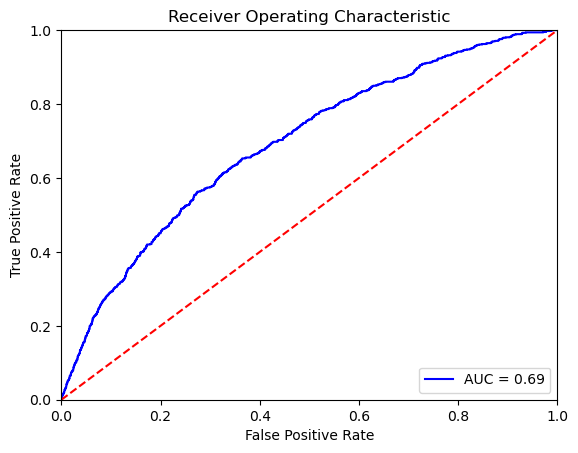

In [149]:
# Plotting AUC Curve

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [150]:
print(rep( y_test , preds_test ))

              precision    recall  f1-score   support

           0       0.95      0.42      0.58      6549
           1       0.15      0.82      0.25       824

    accuracy                           0.46      7373
   macro avg       0.55      0.62      0.42      7373
weighted avg       0.86      0.46      0.54      7373



-------------------------------------------
### Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

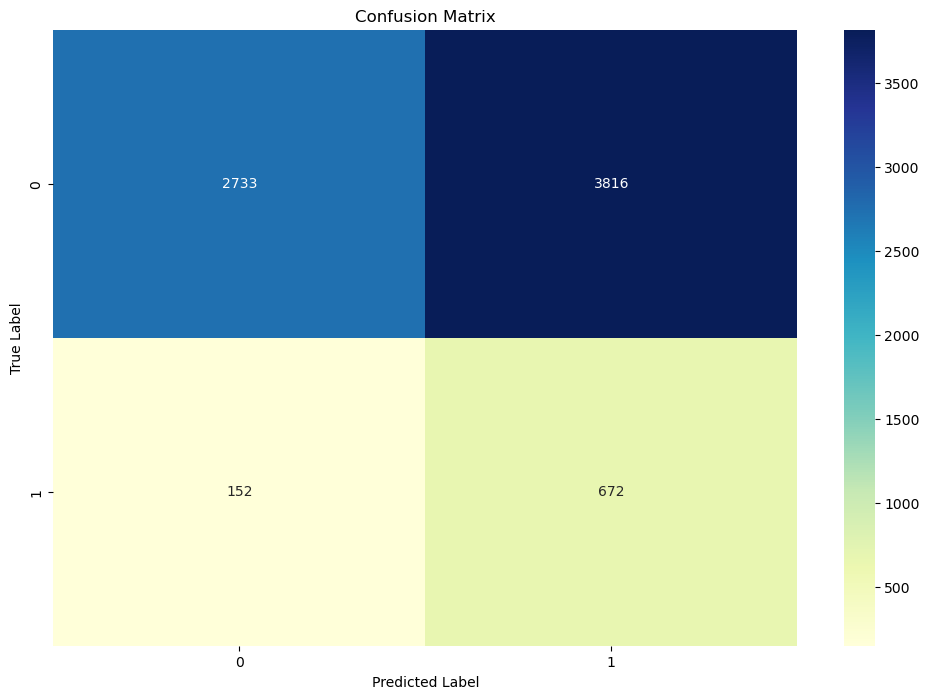

In [151]:
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(confusion_matrix(y_test, preds_test), annot = True, fmt = 'd', cmap="YlGnBu", xticklabels=[0,1],yticklabels=[0,1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

--------------------------------------------------------
### Feature Importance Plot

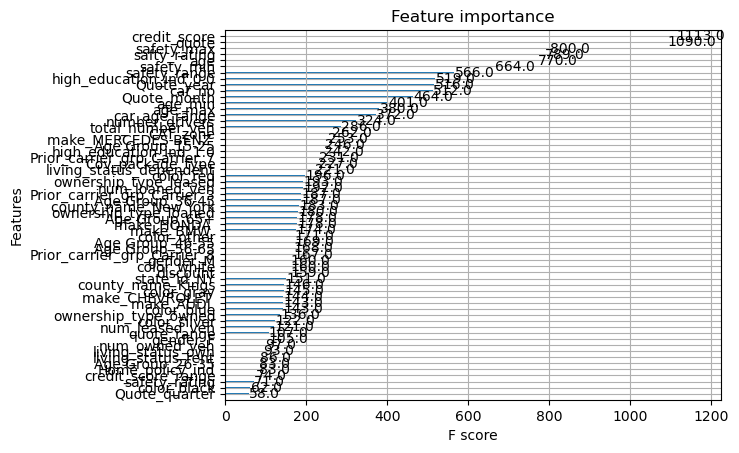

<Figure size 1500x1500 with 0 Axes>

In [152]:
# Plotting Feature importance

xgb.plot_importance(xgb_final)
plt.rcParams['figure.figsize'] = [15, 15]
plt.show()
plt.savefig('sample.pdf')

---------------------------------------------------
### SHAP Values

In [153]:
import shap

In [154]:
explainer = shap.Explainer(xgb_final)
shap_values = explainer(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


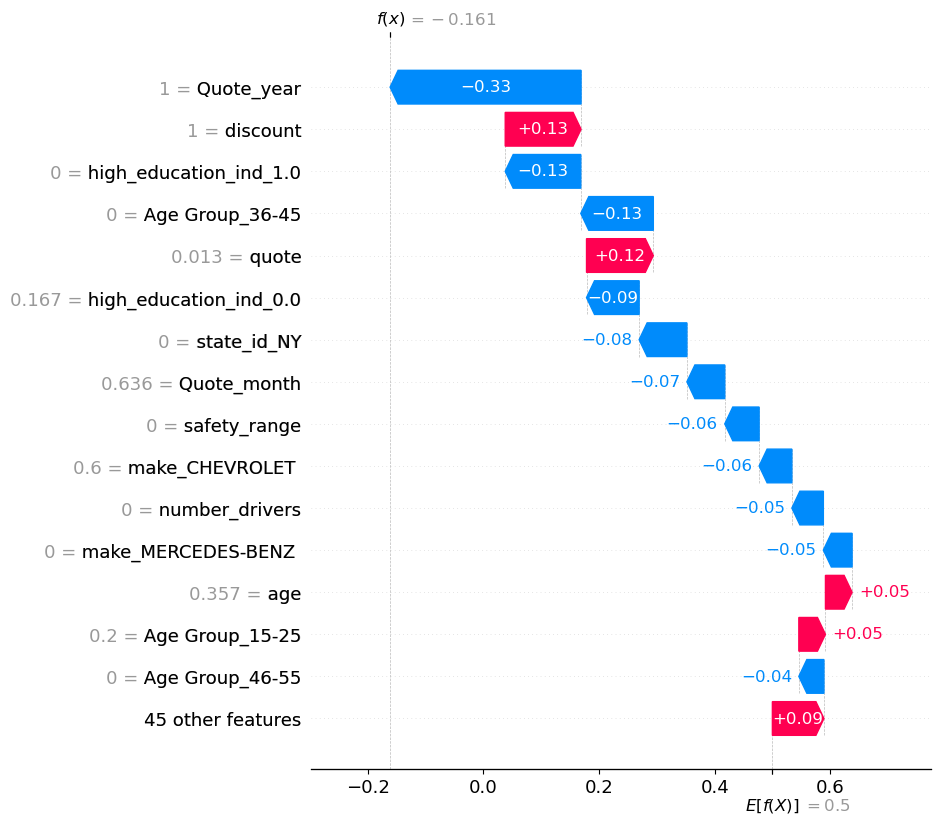

In [155]:
# SHAP waterfall plot
shap.plots.waterfall(shap_values[0], max_display = 16)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


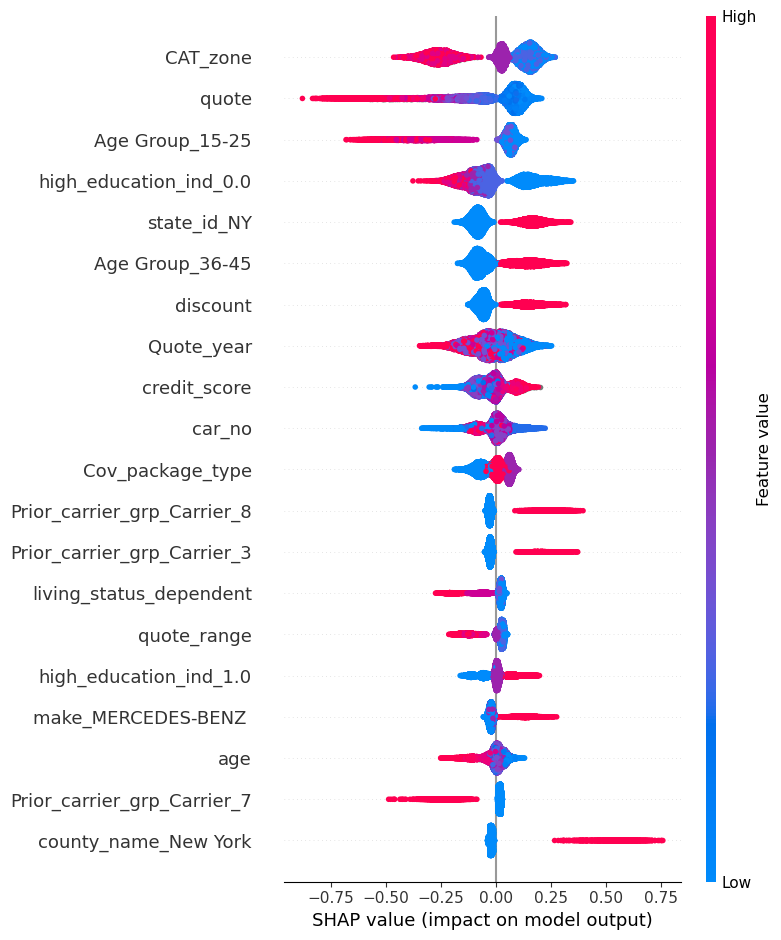

In [156]:
# SHAP Beeswarm Plot
shap.summary_plot(shap_values, X_train)

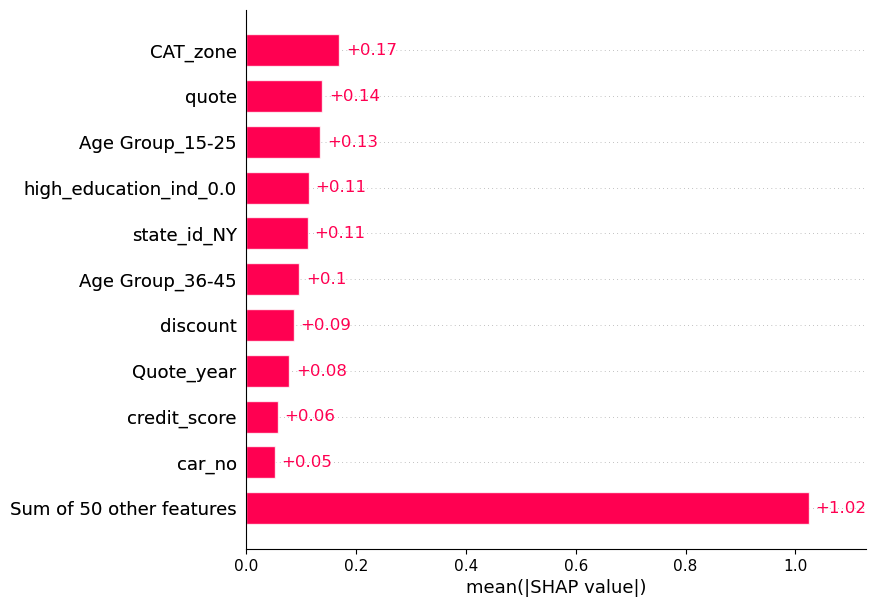

In [157]:
# Shap Bar plot with top 10 features with highest SHAP values
shap.plots.bar(shap_values, max_display = 11)

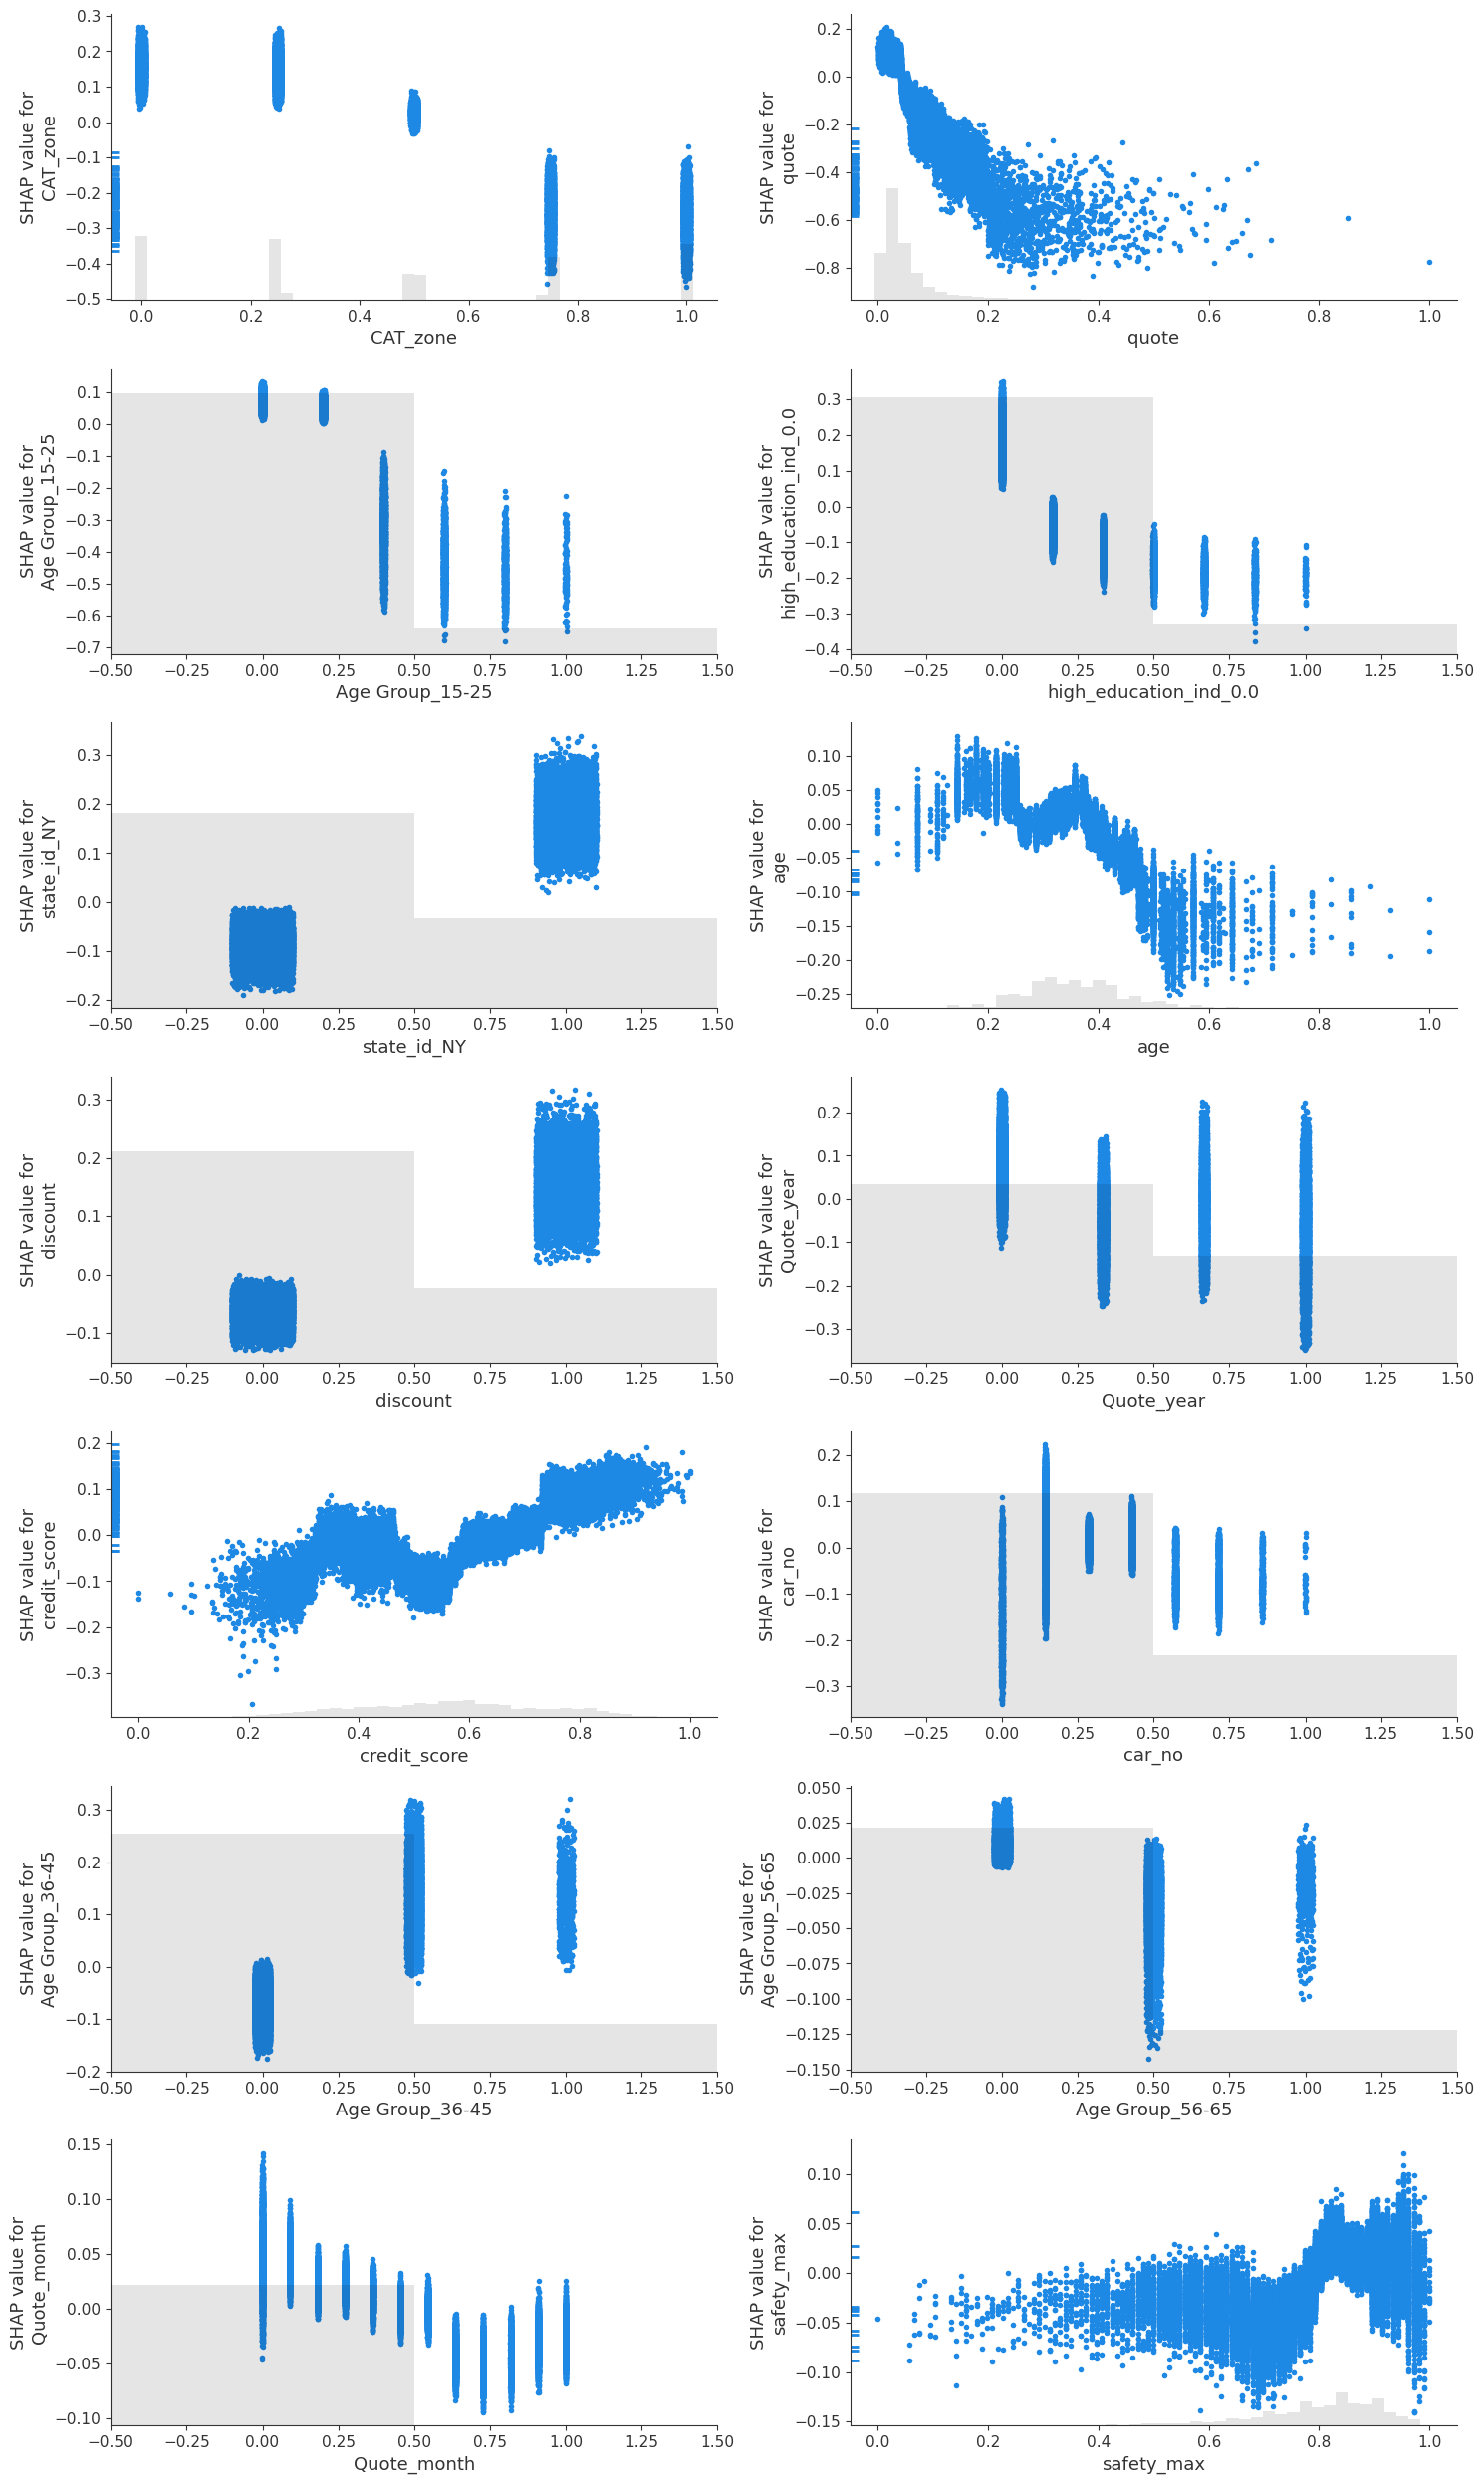

In [158]:
# Plotting SHAP values against features of high importance

fig, ax = plt.subplots(nrows=7, ncols=2,figsize=(15,25))
shap.plots.scatter(shap_values[:,"CAT_zone"],ax=ax[0][0],show=False)
shap.plots.scatter(shap_values[:,"quote"],ax=ax[0][1],show=False)
shap.plots.scatter(shap_values[:,"Age Group_15-25"],ax=ax[1][0],show=False)
shap.plots.scatter(shap_values[:,"high_education_ind_0.0"],ax=ax[1][1],show=False)
shap.plots.scatter(shap_values[:,"state_id_NY"],ax=ax[2][0],show=False)
shap.plots.scatter(shap_values[:,"age"],ax=ax[2][1],show=False)
shap.plots.scatter(shap_values[:,"discount"],ax=ax[3][0],show=False)
shap.plots.scatter(shap_values[:,"Quote_year"],ax=ax[3][1],show=False)
shap.plots.scatter(shap_values[:,"credit_score"],ax=ax[4][0],show=False)
shap.plots.scatter(shap_values[:,"car_no"],ax=ax[4][1],show=False)
shap.plots.scatter(shap_values[:,"Age Group_36-45"],ax=ax[5][0],show=False)
shap.plots.scatter(shap_values[:,"Age Group_56-65"],ax=ax[5][1],show=False)
shap.plots.scatter(shap_values[:,"Quote_month"],ax=ax[6][0],show=False)
fig.tight_layout()
shap.plots.scatter(shap_values[:,"safety_max"],ax=ax[6][1])


-------------------------------------------------
## Findings

### Characteristics of customers likely to convert

* Customers in lower CAT zones
* Lower quotes
* State ID NY 
* More individuals with education indicator as 1
* Offered Discount
* Prior carrier group 3 and 8
* Higher credit score
* Policies having customers in age group 36-45


### Characteristics of customers not likely to convert

* Higher CAT zones
* Higher quote 
* More individuals with education indicator as 0
* Policies not having individuals in age group 15-25
* Higher Vehicle age
* Higher living status dependency
* Having prior carrier group_7
* Lower credit score


## Recommendations:

* **Target customers in New York living in lower CAT zones.**
* **Focus on families with more individuals in the 36-45 age brackets and not in 15-25 age bracket**
* **Policies should be offered at discount and have lower quotes to increase conversions to customers with high credit scores.**
* **Customers having extremely old cars should be avoided.**
* **Pursue higher educated customers who either own or rent homes and are not dependent.**


### Feature additions to Dataset that could help make better Predictions

* Discount Percentage
* Agent rating / Experience
* Prior Insurance Quote
* Car Price
* Annual Income
* Driver Marital Status


--------------------------------
# Kaggle Leaderboard

**Team Name: Rovers**

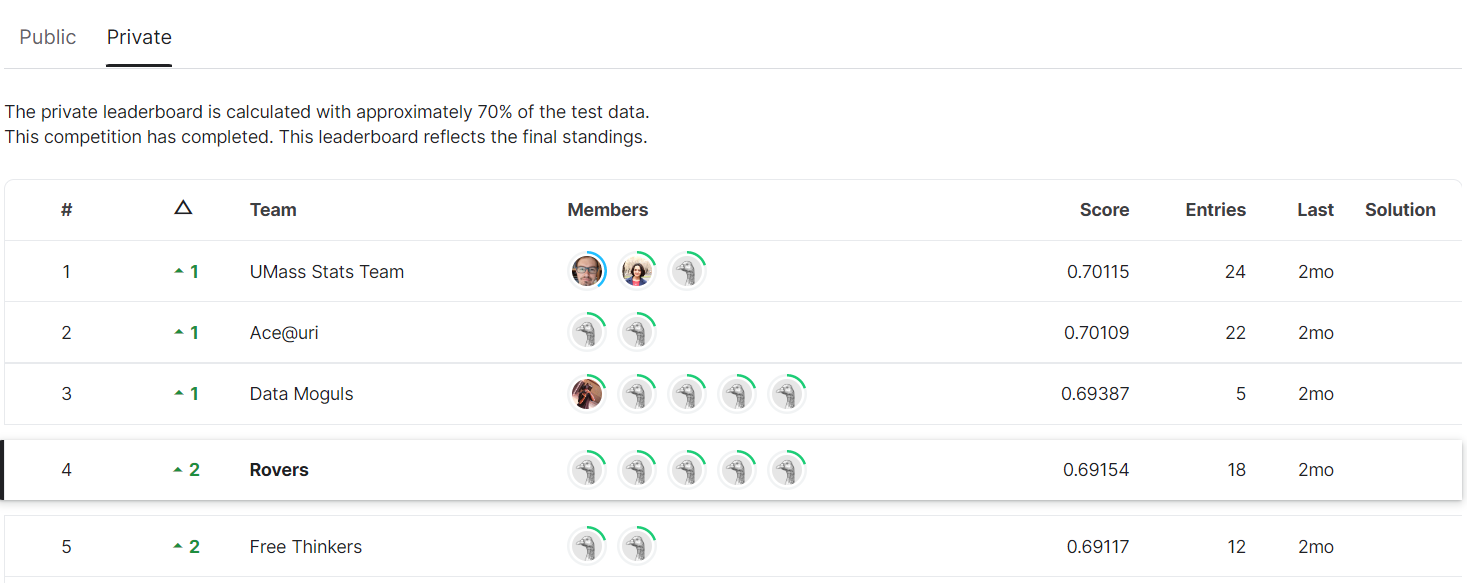

## Predicting on Test Dataset for Kaggle

In [171]:
test.shape

(12291, 22)

In [172]:
test = pd.merge(left = test, right = vvdata, how = 'inner', on = 'policy_id')
test.head()


,Unnamed: 0,Quote_dt,discount,Home_policy_ind,zip,state_id,county_name,Agent_cd,quoted_amt,Prior_carrier_grp,credit_score,Cov_package_type,CAT_zone,policy_id,number_drivers,num_loaned_veh,num_owned_veh,num_leased_veh,total_number_veh,convert_ind,split,primary_parking,car_no,age,age_min,age_max,ownership_type_leased,ownership_type_loaned,ownership_type_owned,color_black,color_blue,color_gray,color_other,color_red,color_silver,color_white,make_ACURA,make_AUDI,make_BMW,make_BUICK,make_CADILLAC,make_CHEVROLET,make_CHRYSLER,make_DODGE,make_FORD,make_GMC,make_HONDA,make_MAZDA,make_MERCEDES-BENZ,make_NISSAN,make_RAM,make_SATURN,make_SMART,make_SUBARU,make_TOYOTA
0,2,12-02-2015,No,N,12801.0,NY,Warren,46978147.0,"$9,870",Carrier_4,576.0,Low,4.0,policy_89288,1,1,1,2,4,NaN,Test,unknown,4,2.75,1.0,4.0,1,1,2,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1
1,4,28-07-2015,No,N,33141.0,FL,Miami-Dade,47310293.0,"$2,860",Carrier_7,573.0,Medium,3.0,policy_23460,1,2,3,0,5,NaN,Test,unknown,2,5.50,3.0,8.0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
2,8,22-01-2015,No,N,8904.0,NJ,Middlesex,45747860.0,"$2,980",Carrier_6,679.0,High,4.0,policy_43809,4,0,2,0,2,NaN,Test,home/driveway,2,3.00,1.0,5.0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,9,15-01-2018,No,N,6907.0,CT,Fairfield,30895563.0,"$1,945",NaN,773.0,Low,2.0,policy_4590,3,1,3,2,6,NaN,Test,unknown,4,3.00,2.0,4.0,0,2,2,1,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,1,2,0,0,0,0,0,0,0,0
4,10,01-08-2017,No,N,11550.0,NY,Nassau,33958256.0,"$5,829",Carrier_1,680.0,Low,1.0,policy_65525,1,2,3,0,5,NaN,Test,unknown,5,4.20,3.0,5.0,2,0,3,0,2,0,0,0,1,2,0,0,0,1,0,0,0,0,0,0,0,2,0,0,1,0,0,0,1


In [173]:
test.shape

(12291, 55)

In [174]:
test = pd.merge(left = test, right = dddata, how = 'left', on = 'policy_id')
test.head()

,Unnamed: 0,Quote_dt,discount,Home_policy_ind,zip,state_id,county_name,Agent_cd,quoted_amt,Prior_carrier_grp,credit_score,Cov_package_type,CAT_zone,policy_id,number_drivers,num_loaned_veh,num_owned_veh,num_leased_veh,total_number_veh,convert_ind,split,primary_parking,car_no,age,age_min,age_max,ownership_type_leased,ownership_type_loaned,ownership_type_owned,color_black,color_blue,color_gray,color_other,color_red,color_silver,color_white,make_ACURA,make_AUDI,make_BMW,make_BUICK,make_CADILLAC,make_CHEVROLET,make_CHRYSLER,make_DODGE,make_FORD,make_GMC,make_HONDA,make_MAZDA,make_MERCEDES-BENZ,make_NISSAN,make_RAM,make_SATURN,make_SMART,make_SUBARU,make_TOYOTA,safty_rating,safety_min,safety_max,gender_F,gender_M,living_status_dependent,living_status_own,living_status_rent,Age Group_15-25,Age Group_26-35,Age Group_36-45,Age Group_46-55,Age Group_56-65,Age Group_65+,high_education_ind_0.0,high_education_ind_1.0
0,2,12-02-2015,No,N,12801.0,NY,Warren,46978147.0,"$9,870",Carrier_4,576.0,Low,4.0,policy_89288,1,1,1,2,4,NaN,Test,unknown,4,2.75,1.0,4.0,1,1,2,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,62.000000,62.0,62.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,4,28-07-2015,No,N,33141.0,FL,Miami-Dade,47310293.0,"$2,860",Carrier_7,573.0,Medium,3.0,policy_23460,1,2,3,0,5,NaN,Test,unknown,2,5.50,3.0,8.0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,90.000000,90.0,90.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,8,22-01-2015,No,N,8904.0,NJ,Middlesex,45747860.0,"$2,980",Carrier_6,679.0,High,4.0,policy_43809,4,0,2,0,2,NaN,Test,home/driveway,2,3.00,1.0,5.0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,59.500000,37.0,91.0,3.0,1.0,3.0,1.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0
3,9,15-01-2018,No,N,6907.0,CT,Fairfield,30895563.0,"$1,945",NaN,773.0,Low,2.0,policy_4590,3,1,3,2,6,NaN,Test,unknown,4,3.00,2.0,4.0,0,2,2,1,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,1,2,0,0,0,0,0,0,0,0,64.666667,56.0,80.0,2.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0
4,10,01-08-2017,No,N,11550.0,NY,Nassau,33958256.0,"$5,829",Carrier_1,680.0,Low,1.0,policy_65525,1,2,3,0,5,NaN,Test,unknown,5,4.20,3.0,5.0,2,0,3,0,2,0,0,0,1,2,0,0,0,1,0,0,0,0,0,0,0,2,0,0,1,0,0,0,1,72.000000,72.0,72.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [175]:
test.shape

(12291, 71)

In [176]:
submission = pd.DataFrame(columns = ['policy_id', 'TARGET'])
submission['policy_id'] = test['policy_id']

In [177]:
test['quote'] = test['quoted_amt'].str.replace(',','')
test['quote'] = test['quote'].str.replace('$','')
test['quote'] = pd.to_numeric(test['quote'], errors='coerce')
test['quote'].dtype

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


dtype('float64')

In [178]:
bins = [0,2500,5000,7500,10000,200000]
labels = ['Very Low','Low','Medium','High','Very High']
test['quote_range'] = pd.cut(test['quote'], bins = bins, labels = labels)
test.head()

,Unnamed: 0,Quote_dt,discount,Home_policy_ind,zip,state_id,county_name,Agent_cd,quoted_amt,Prior_carrier_grp,credit_score,Cov_package_type,CAT_zone,policy_id,number_drivers,num_loaned_veh,num_owned_veh,num_leased_veh,total_number_veh,convert_ind,split,primary_parking,car_no,age,age_min,age_max,ownership_type_leased,ownership_type_loaned,ownership_type_owned,color_black,color_blue,color_gray,color_other,color_red,color_silver,color_white,make_ACURA,make_AUDI,make_BMW,make_BUICK,make_CADILLAC,make_CHEVROLET,make_CHRYSLER,make_DODGE,make_FORD,make_GMC,make_HONDA,make_MAZDA,make_MERCEDES-BENZ,make_NISSAN,make_RAM,make_SATURN,make_SMART,make_SUBARU,make_TOYOTA,safty_rating,safety_min,safety_max,gender_F,gender_M,living_status_dependent,living_status_own,living_status_rent,Age Group_15-25,Age Group_26-35,Age Group_36-45,Age Group_46-55,Age Group_56-65,Age Group_65+,high_education_ind_0.0,high_education_ind_1.0,quote,quote_range
0,2,12-02-2015,No,N,12801.0,NY,Warren,46978147.0,"$9,870",Carrier_4,576.0,Low,4.0,policy_89288,1,1,1,2,4,NaN,Test,unknown,4,2.75,1.0,4.0,1,1,2,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,62.000000,62.0,62.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,9870.0,High
1,4,28-07-2015,No,N,33141.0,FL,Miami-Dade,47310293.0,"$2,860",Carrier_7,573.0,Medium,3.0,policy_23460,1,2,3,0,5,NaN,Test,unknown,2,5.50,3.0,8.0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,90.000000,90.0,90.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2860.0,Low
2,8,22-01-2015,No,N,8904.0,NJ,Middlesex,45747860.0,"$2,980",Carrier_6,679.0,High,4.0,policy_43809,4,0,2,0,2,NaN,Test,home/driveway,2,3.00,1.0,5.0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,59.500000,37.0,91.0,3.0,1.0,3.0,1.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,2980.0,Low
3,9,15-01-2018,No,N,6907.0,CT,Fairfield,30895563.0,"$1,945",NaN,773.0,Low,2.0,policy_4590,3,1,3,2,6,NaN,Test,unknown,4,3.00,2.0,4.0,0,2,2,1,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,1,2,0,0,0,0,0,0,0,0,64.666667,56.0,80.0,2.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,1945.0,Very Low
4,10,01-08-2017,No,N,11550.0,NY,Nassau,33958256.0,"$5,829",Carrier_1,680.0,Low,1.0,policy_65525,1,2,3,0,5,NaN,Test,unknown,5,4.20,3.0,5.0,2,0,3,0,2,0,0,0,1,2,0,0,0,1,0,0,0,0,0,0,0,2,0,0,1,0,0,0,1,72.000000,72.0,72.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,5829.0,Medium


In [179]:
test['log_quote'] = np.log(test['quote'])

In [180]:
test.shape

(12291, 74)

In [181]:
test['total_drivers'] = df_policy['gender_F']+df_policy['gender_M']

In [182]:
#test.drop(test[test['number_drivers'] != test['total_drivers']].index, axis = 0, inplace = True)

In [183]:
test.shape

(12291, 75)

In [184]:
bins = [0,59,69,79,89,100]
labels = ['Very Low','Low','Medium','High','Very High']
test['safety_rating'] = pd.cut(test['safty_rating'], bins = bins, labels = labels)
test.head(5)

,Unnamed: 0,Quote_dt,discount,Home_policy_ind,zip,state_id,county_name,Agent_cd,quoted_amt,Prior_carrier_grp,credit_score,Cov_package_type,CAT_zone,policy_id,number_drivers,num_loaned_veh,num_owned_veh,num_leased_veh,total_number_veh,convert_ind,split,primary_parking,car_no,age,age_min,age_max,ownership_type_leased,ownership_type_loaned,ownership_type_owned,color_black,color_blue,color_gray,color_other,color_red,color_silver,color_white,make_ACURA,make_AUDI,make_BMW,make_BUICK,make_CADILLAC,make_CHEVROLET,make_CHRYSLER,make_DODGE,make_FORD,make_GMC,make_HONDA,make_MAZDA,make_MERCEDES-BENZ,make_NISSAN,make_RAM,make_SATURN,make_SMART,make_SUBARU,make_TOYOTA,safty_rating,safety_min,safety_max,gender_F,gender_M,living_status_dependent,living_status_own,living_status_rent,Age Group_15-25,Age Group_26-35,Age Group_36-45,Age Group_46-55,Age Group_56-65,Age Group_65+,high_education_ind_0.0,high_education_ind_1.0,quote,quote_range,log_quote,total_drivers,safety_rating
0,2,12-02-2015,No,N,12801.0,NY,Warren,46978147.0,"$9,870",Carrier_4,576.0,Low,4.0,policy_89288,1,1,1,2,4,NaN,Test,unknown,4,2.75,1.0,4.0,1,1,2,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,62.000000,62.0,62.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,9870.0,High,9.197255,2.0,Low
1,4,28-07-2015,No,N,33141.0,FL,Miami-Dade,47310293.0,"$2,860",Carrier_7,573.0,Medium,3.0,policy_23460,1,2,3,0,5,NaN,Test,unknown,2,5.50,3.0,8.0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,90.000000,90.0,90.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2860.0,Low,7.958577,2.0,Very High
2,8,22-01-2015,No,N,8904.0,NJ,Middlesex,45747860.0,"$2,980",Carrier_6,679.0,High,4.0,policy_43809,4,0,2,0,2,NaN,Test,home/driveway,2,3.00,1.0,5.0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,59.500000,37.0,91.0,3.0,1.0,3.0,1.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,2980.0,Low,7.999679,2.0,Low
3,9,15-01-2018,No,N,6907.0,CT,Fairfield,30895563.0,"$1,945",NaN,773.0,Low,2.0,policy_4590,3,1,3,2,6,NaN,Test,unknown,4,3.00,2.0,4.0,0,2,2,1,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,1,2,0,0,0,0,0,0,0,0,64.666667,56.0,80.0,2.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,1945.0,Very Low,7.573017,1.0,Low
4,10,01-08-2017,No,N,11550.0,NY,Nassau,33958256.0,"$5,829",Carrier_1,680.0,Low,1.0,policy_65525,1,2,3,0,5,NaN,Test,unknown,5,4.20,3.0,5.0,2,0,3,0,2,0,0,0,1,2,0,0,0,1,0,0,0,0,0,0,0,2,0,0,1,0,0,0,1,72.000000,72.0,72.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,5829.0,Medium,8.670601,4.0,Medium


In [185]:
test['county_name'] = np.where((test['county_name'] == 'New York')|(test['county_name'] =='Kings'), test['county_name'], 0)

In [186]:
test['Prior_carrier_grp'] = np.where((test['Prior_carrier_grp'] == 'Carrier_3')|(test['Prior_carrier_grp'] =='Carrier_7')|(test['Prior_carrier_grp'] =='Carrier_8'), test['Prior_carrier_grp'], 0)

In [187]:
test.drop(['make_ACURA ', 'make_BUICK ', 'make_CADILLAC ', 'make_CHRYSLER ', 'make_DODGE ','make_FORD ', 'make_GMC ','make_MAZDA ',
                'make_NISSAN ','make_RAM ','make_SATURN ','make_SMART ','make_SUBARU ','make_TOYOTA '], axis = 1, inplace = True)

In [188]:
test.columns

Index(['Unnamed: 0', 'Quote_dt', 'discount', 'Home_policy_ind', 'zip',
       'state_id', 'county_name', 'Agent_cd', 'quoted_amt',
       'Prior_carrier_grp', 'credit_score', 'Cov_package_type', 'CAT_zone',
       'policy_id', 'number_drivers', 'num_loaned_veh', 'num_owned_veh',
       'num_leased_veh', 'total_number_veh', 'convert_ind', 'split',
       'primary_parking', 'car_no', 'age', 'age_min', 'age_max',
       'ownership_type_leased', 'ownership_type_loaned',
       'ownership_type_owned', 'color_black', 'color_blue', 'color_gray',
       'color_other', 'color_red', 'color_silver', 'color_white', 'make_AUDI ',
       'make_BMW ', 'make_CHEVROLET ', 'make_HONDA ', 'make_MERCEDES-BENZ ',
       'safty_rating', 'safety_min', 'safety_max', 'gender_F', 'gender_M',
       'living_status_dependent', 'living_status_own', 'living_status_rent',
       'Age Group_15-25', 'Age Group_26-35', 'Age Group_36-45',
       'Age Group_46-55', 'Age Group_56-65', 'Age Group_65+',
       'high_educati

In [189]:
bins = [0,500,600,700,800,850]
labels = ['Very Low','Low','Medium','High','Very High']
test['credit_score_range'] = pd.cut(test['credit_score'], bins = bins, labels = labels)

In [190]:
test.drop(['quoted_amt', 'total_drivers'], axis = 1, inplace = True)

In [191]:
test['safety_range'] = test['safety_max'] - test['safety_min']
test['car_age_range'] = test['age_max'] - test['age_min']

In [192]:
test['Quote_dt'] = pd.to_datetime(test['Quote_dt'])

In [193]:
test['Quote_month'] = test['Quote_dt'].dt.month
test['Quote_quarter'] = test['Quote_dt'].dt.quarter
test['Quote_year'] = test['Quote_dt'].dt.year

In [194]:
test.drop(['split', 'Unnamed: 0', 'Quote_dt', 'zip', 'Agent_cd', 'policy_id'], axis = 1, inplace=True)

In [195]:
test = pd.get_dummies(test, columns = ['state_id','Prior_carrier_grp', 'primary_parking', 'county_name' ])

In [196]:
test['discount'] = test['discount'].astype('category')
test['Home_policy_ind'] = test['Home_policy_ind'].astype('category')
test['Cov_package_type'] = test['Cov_package_type'].astype('category')

In [197]:
test['credit_score_range'] = test['credit_score_range'].cat.codes
test['Home_policy_ind'] = test['Home_policy_ind'].cat.codes
test['Cov_package_type'] = test['Cov_package_type'].cat.codes
test['safety_rating'] = test['safety_rating'].cat.codes
test['discount'] = test['discount'].cat.codes
test['quote_range'] = test['quote_range'].cat.codes

In [198]:
test.drop(['primary_parking_home/driveway', 'primary_parking_parking garage',
       'primary_parking_street', 'primary_parking_unknown', 'state_id_AL', 'state_id_CT', 'state_id_FL',
       'state_id_GA', 'state_id_MN', 'state_id_NJ',
       'state_id_WI'], axis = 1, inplace = True)

In [199]:
test.columns

Index(['discount', 'Home_policy_ind', 'credit_score', 'Cov_package_type',
       'CAT_zone', 'number_drivers', 'num_loaned_veh', 'num_owned_veh',
       'num_leased_veh', 'total_number_veh', 'convert_ind', 'car_no', 'age',
       'age_min', 'age_max', 'ownership_type_leased', 'ownership_type_loaned',
       'ownership_type_owned', 'color_black', 'color_blue', 'color_gray',
       'color_other', 'color_red', 'color_silver', 'color_white', 'make_AUDI ',
       'make_BMW ', 'make_CHEVROLET ', 'make_HONDA ', 'make_MERCEDES-BENZ ',
       'safty_rating', 'safety_min', 'safety_max', 'gender_F', 'gender_M',
       'living_status_dependent', 'living_status_own', 'living_status_rent',
       'Age Group_15-25', 'Age Group_26-35', 'Age Group_36-45',
       'Age Group_46-55', 'Age Group_56-65', 'Age Group_65+',
       'high_education_ind_0.0', 'high_education_ind_1.0', 'quote',
       'quote_range', 'log_quote', 'safety_rating', 'credit_score_range',
       'safety_range', 'car_age_range', 'Quote_

In [200]:
test.drop(['log_quote', 'Prior_carrier_grp_0', 'county_name_0'], axis = 1, inplace=True)

In [201]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12291 entries, 0 to 12290
Data columns (total 61 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   discount                     12291 non-null  int8   
 1   Home_policy_ind              12291 non-null  int8   
 2   credit_score                 12215 non-null  float64
 3   Cov_package_type             12291 non-null  int8   
 4   CAT_zone                     12222 non-null  float64
 5   number_drivers               12291 non-null  int64  
 6   num_loaned_veh               12291 non-null  int64  
 7   num_owned_veh                12291 non-null  int64  
 8   num_leased_veh               12291 non-null  int64  
 9   total_number_veh             12291 non-null  int64  
 10  convert_ind                  0 non-null      float64
 11  car_no                       12291 non-null  int64  
 12  age                          12288 non-null  float64
 13  age_min         

In [202]:
test_x = test.drop(['convert_ind'], axis = 1)

In [203]:
scaler = MinMaxScaler()
test_x_scaled = scaler.fit_transform(test_x)
test_x_scaled = pd.DataFrame(test_x_scaled, columns=test_x.columns)

In [204]:
#xgb_final.fit(train_x_scaled,y)

In [205]:
test_y = xgb_final.predict(test_x_scaled)

In [206]:
#print("Accuracy of Model::",accuracy_score(test_y,test_preds))

In [207]:
test_prob = xgb_final.predict_proba(test_x_scaled)
test_prob

array([[0.6839777 , 0.31602228],
       [0.35455137, 0.6454486 ],
       [0.71101224, 0.2889878 ],
       ...,
       [0.65635157, 0.34364843],
       [0.5269954 , 0.4730046 ],
       [0.56227374, 0.43772626]], dtype=float32)

In [208]:
submission.shape

(12291, 2)

In [209]:
c = pd.DataFrame(test_prob[:,1].tolist(), columns = ['predictions'])
c.head()

,predictions
0,0.316022
1,0.645449
2,0.288988
3,0.631269
4,0.462470


In [210]:
submission['TARGET'] = c['predictions']

In [211]:
submission.head()

,policy_id,TARGET
0,policy_89288,0.316022
1,policy_23460,0.645449
2,policy_43809,0.288988
3,policy_4590,0.631269
4,policy_65525,0.462470


In [212]:
#submission.to_csv('test_predictions18.csv')